# 条件推断树CIT(Conditional Inference Tree)

Conditional inference trees are available in the party package via the ctree() function. However, the **partykit** package contains an improved reimplementation of ctree() and is recommended for ﬁtting individual conditional inference trees in general. 

The ctree() function in partykit is much more modular and written almost entirely in R; this ﬂexibility seems to come at a price, however, as partykit::ctree() can be much slower than party::ctree() (the latter of which is implemented in C). 

It’s also worth noting that partykit is quite extensible and allows you to coerce tree models from diﬀerent sources into a standard format that partykit can work with(e.g., importing trees saved in the predictive model markup language (PMML)format).

Don't try to search for binary splits in unordered factors with more than **31 levels** in partykit. This potentially caused an integer overrun in previous versions. party::ctree() uses an approximation for binary split searches in unordered factors; thus, using party might be an alternative.

## 特点
1. 分枝时不偏向选择取值多的变量
2. 按照提前设定p值预剪枝

## 算法

 1. Individually test the null hypothesis of independence between each of the
m features $X_1$,$X_2$,. . . , $X_m$ and the response $Y$ using the conditional inference approach .If none of these hypotheses can
be rejected at a prespeciﬁed α level, then stop the procedure (i.e., no further splits occur). Otherwise, select the predictor $X_j$ with the “strongest
association” to $Y$,as measured by the corresponding multiplicity adjusted
p-values (e.g., Bonferroni corrected p-values).
1. Use $X_j$,the partitioning variable selected in step 1), to partition the data
into two disjoint subsets (or child nodes), $A_L$ and $A_R$.For each possible
split S,a standardized test statistic (3.3) is computed, and the partition
associated with **the largest test statistic** is used to partition the data into
two child nodes.
1. Repeat steps 1)–2) in a recursive fashion on the resulting child nodes until
the global hypothesis in step 1) cannot be rejected at a prespeciﬁed α
level.

    --可见，最关键地，CIT是把变量选择与分枝点选择分成二个步骤,而rpart等算法是二者合一，CIT克服了rpart等算法分枝偏向于取值多的变量的问题。
  
下面验证此问题：

In [1]:
options(warn=-1)    #忽略一切警告
options('width'=140)  #充分利用打印宽度
options(repr.plot.width=15, repr.plot.height=10)  #满幅

library(pacman)
p_load(rpart,party)

x1~x5为类别型变量，类别个数依次增加。x1~x5的取值都独立于y。

由下可见，rpart全部选择x5作为分枝变量，而CIT无此偏向--不能拒绝x1~x5独立于y，不能选出分枝变量。

  |==================================================================================================================================| 100%

s_rt
 x5 Sum 
100 100 

s_ct
  1   4 Sum 
  1   1   2 

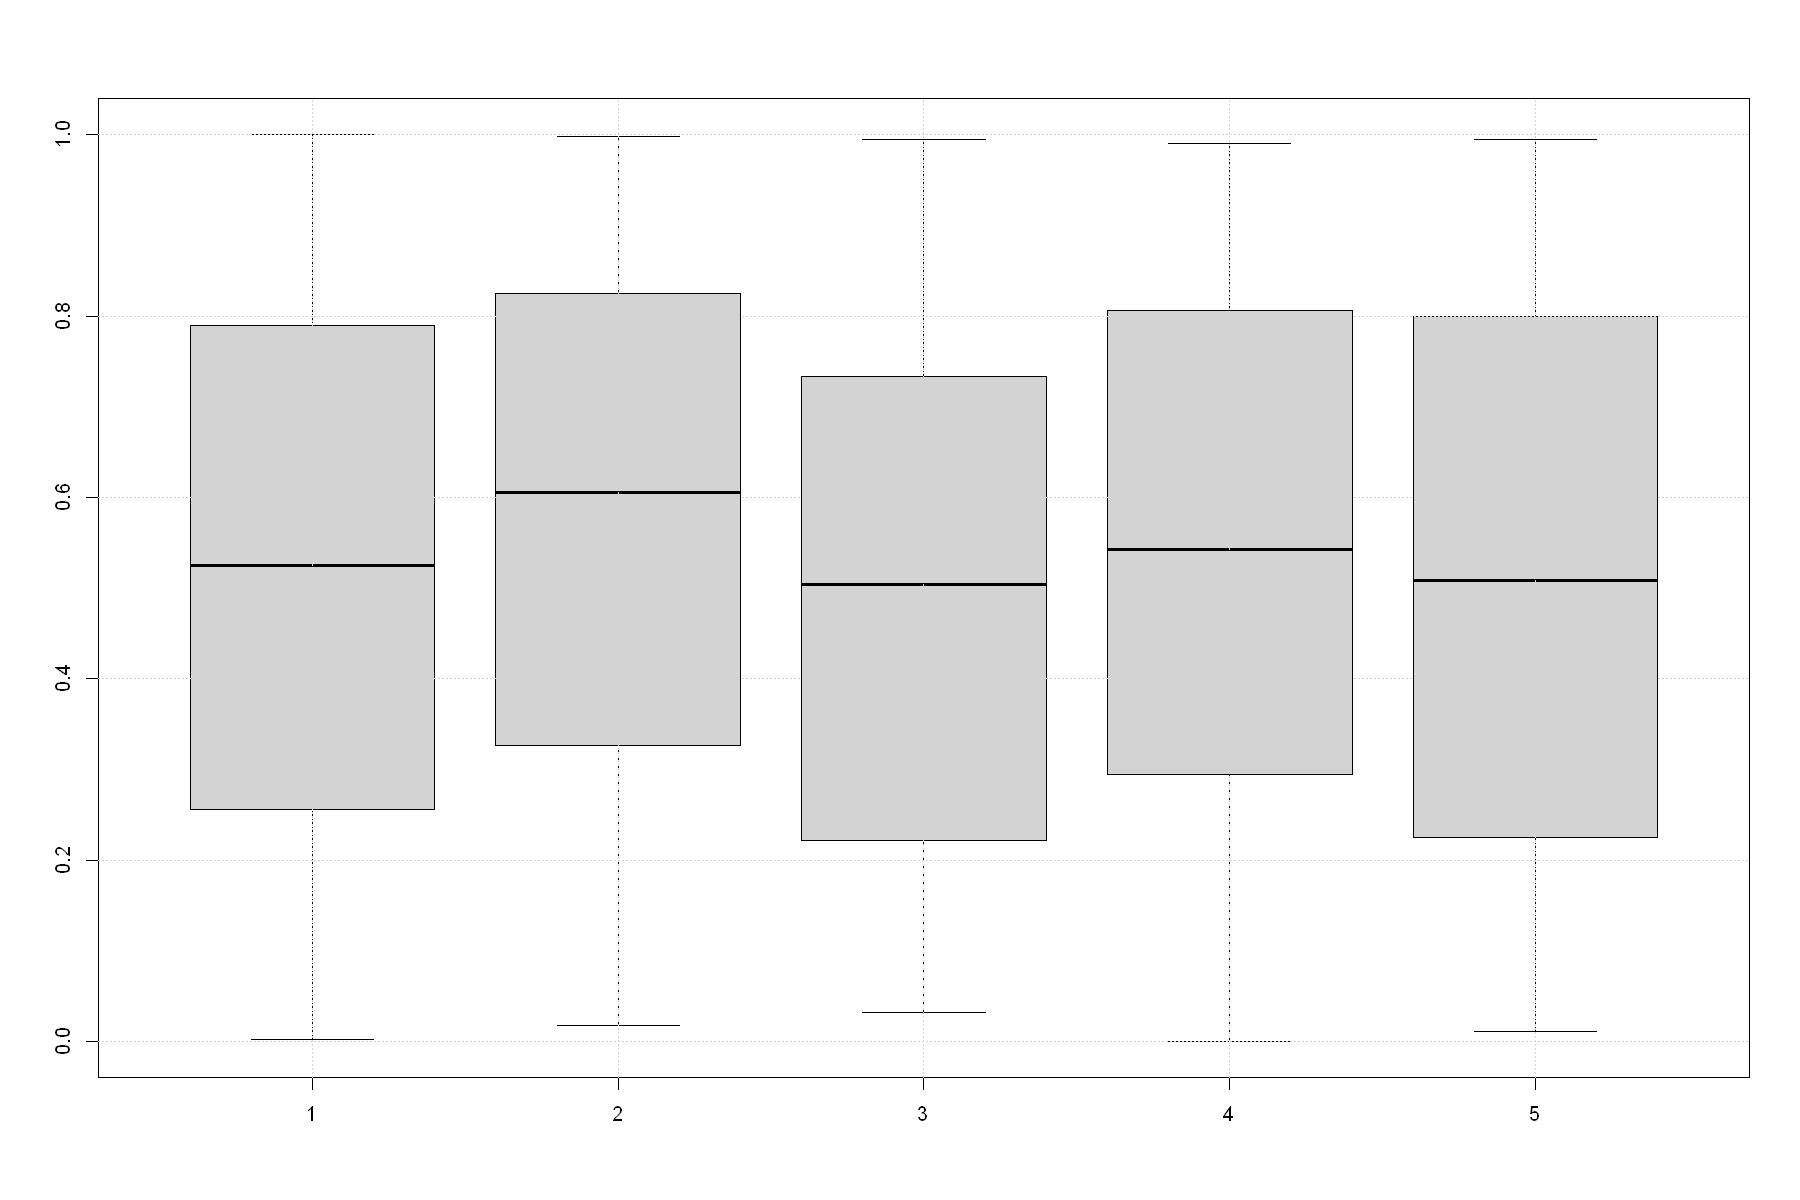

In [3]:
n <- 100 # number of experiment
p1 <- p2 <- p3 <- p4 <- p5 <- s_rt <- s_ct <- c()

pb <- txtProgressBar(style = 3)
# x1~x5均与y独立
for (i in 1:n) {
  set.seed(i + n + 1)
  x1 <- factor((sample(500) %% 2)) # 2种取值
  set.seed(i + n + 2)
  x2 <- factor((sample(500) %% 10)) # 10种取值
  set.seed(i + n + 3)
  x3 <- factor((sample(500) %% 20)) # 20种取值
  set.seed(i + n + 4)
  x4 <- factor((sample(500) %% 50)) # 50种取值
  set.seed(i + n + 5)
  x5 <- factor((sample(500) %% 100)) # 100种取值
  set.seed(i + n)
  y <- factor((sample(500) %% 2))

  p1 <- c(p1, chisq.test(table(x1, y), simulate.p.value = TRUE)$p.value)
  p2 <- c(p2, chisq.test(table(x2, y), simulate.p.value = TRUE)$p.value)
  p3 <- c(p3, chisq.test(table(x3, y), simulate.p.value = TRUE)$p.value)
  p4 <- c(p4, chisq.test(table(x4, y), simulate.p.value = TRUE)$p.value)
  p5 <- c(p5, chisq.test(table(x5, y), simulate.p.value = TRUE)$p.value)

  dt <- data.frame(x1, x2, x3, x4, x5, y)
  rt <- rpart(y ~ ., data = dt, method = "class", cp = 0)
  ct <- ctree(y ~ ., data = dt)
  s_rt <- c(s_rt, rownames(rt$splits)[1])    # 记录rpart选中作为根节点分枝的属性
  s_ct <- c(s_ct, ct@tree$psplit$variableID) # 记录ctree选中作为根节点分枝的属性
  setTxtProgressBar(pb, i / n)
}
addmargins(table(s_rt)) # rpart选中作为根节点分枝的属性的次数
addmargins(table(s_ct)) # ctree选中作为根节点分枝的属性的次数
boxplot(p1, p2, p3, p4, p5) # 可见x1~x5的p值都较大，CIT不会倾向选择x5
grid()

可见100次试验，根节点分枝：
- rpart均选取了取值类别数最多x5
- CIT共有二次分枝，但没有选取x5

x1~x5分别与y的独立性检验的p值示例：

In [4]:
chisq.test(table(x1, y),simulate.p.value = TRUE)$p.value
chisq.test(table(x2, y),simulate.p.value = TRUE)$p.value
chisq.test(table(x3, y),simulate.p.value = TRUE)$p.value
chisq.test(table(x4, y),simulate.p.value = TRUE)$p.value
chisq.test(table(x5, y),simulate.p.value = TRUE)$p.value

[1] 0.9205397

[1] 0.9195402

[1] 0.5577211

[1] 0.7441279

[1] 0.1094453

x1~x5的p值较大，不能推翻与y独立的假设，不能入围分枝变量的选择

## 直观观察

### 分类界线

In [22]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(partykit,rpart,skimr)
s <- skim_tee

**构建训练集、测试集**

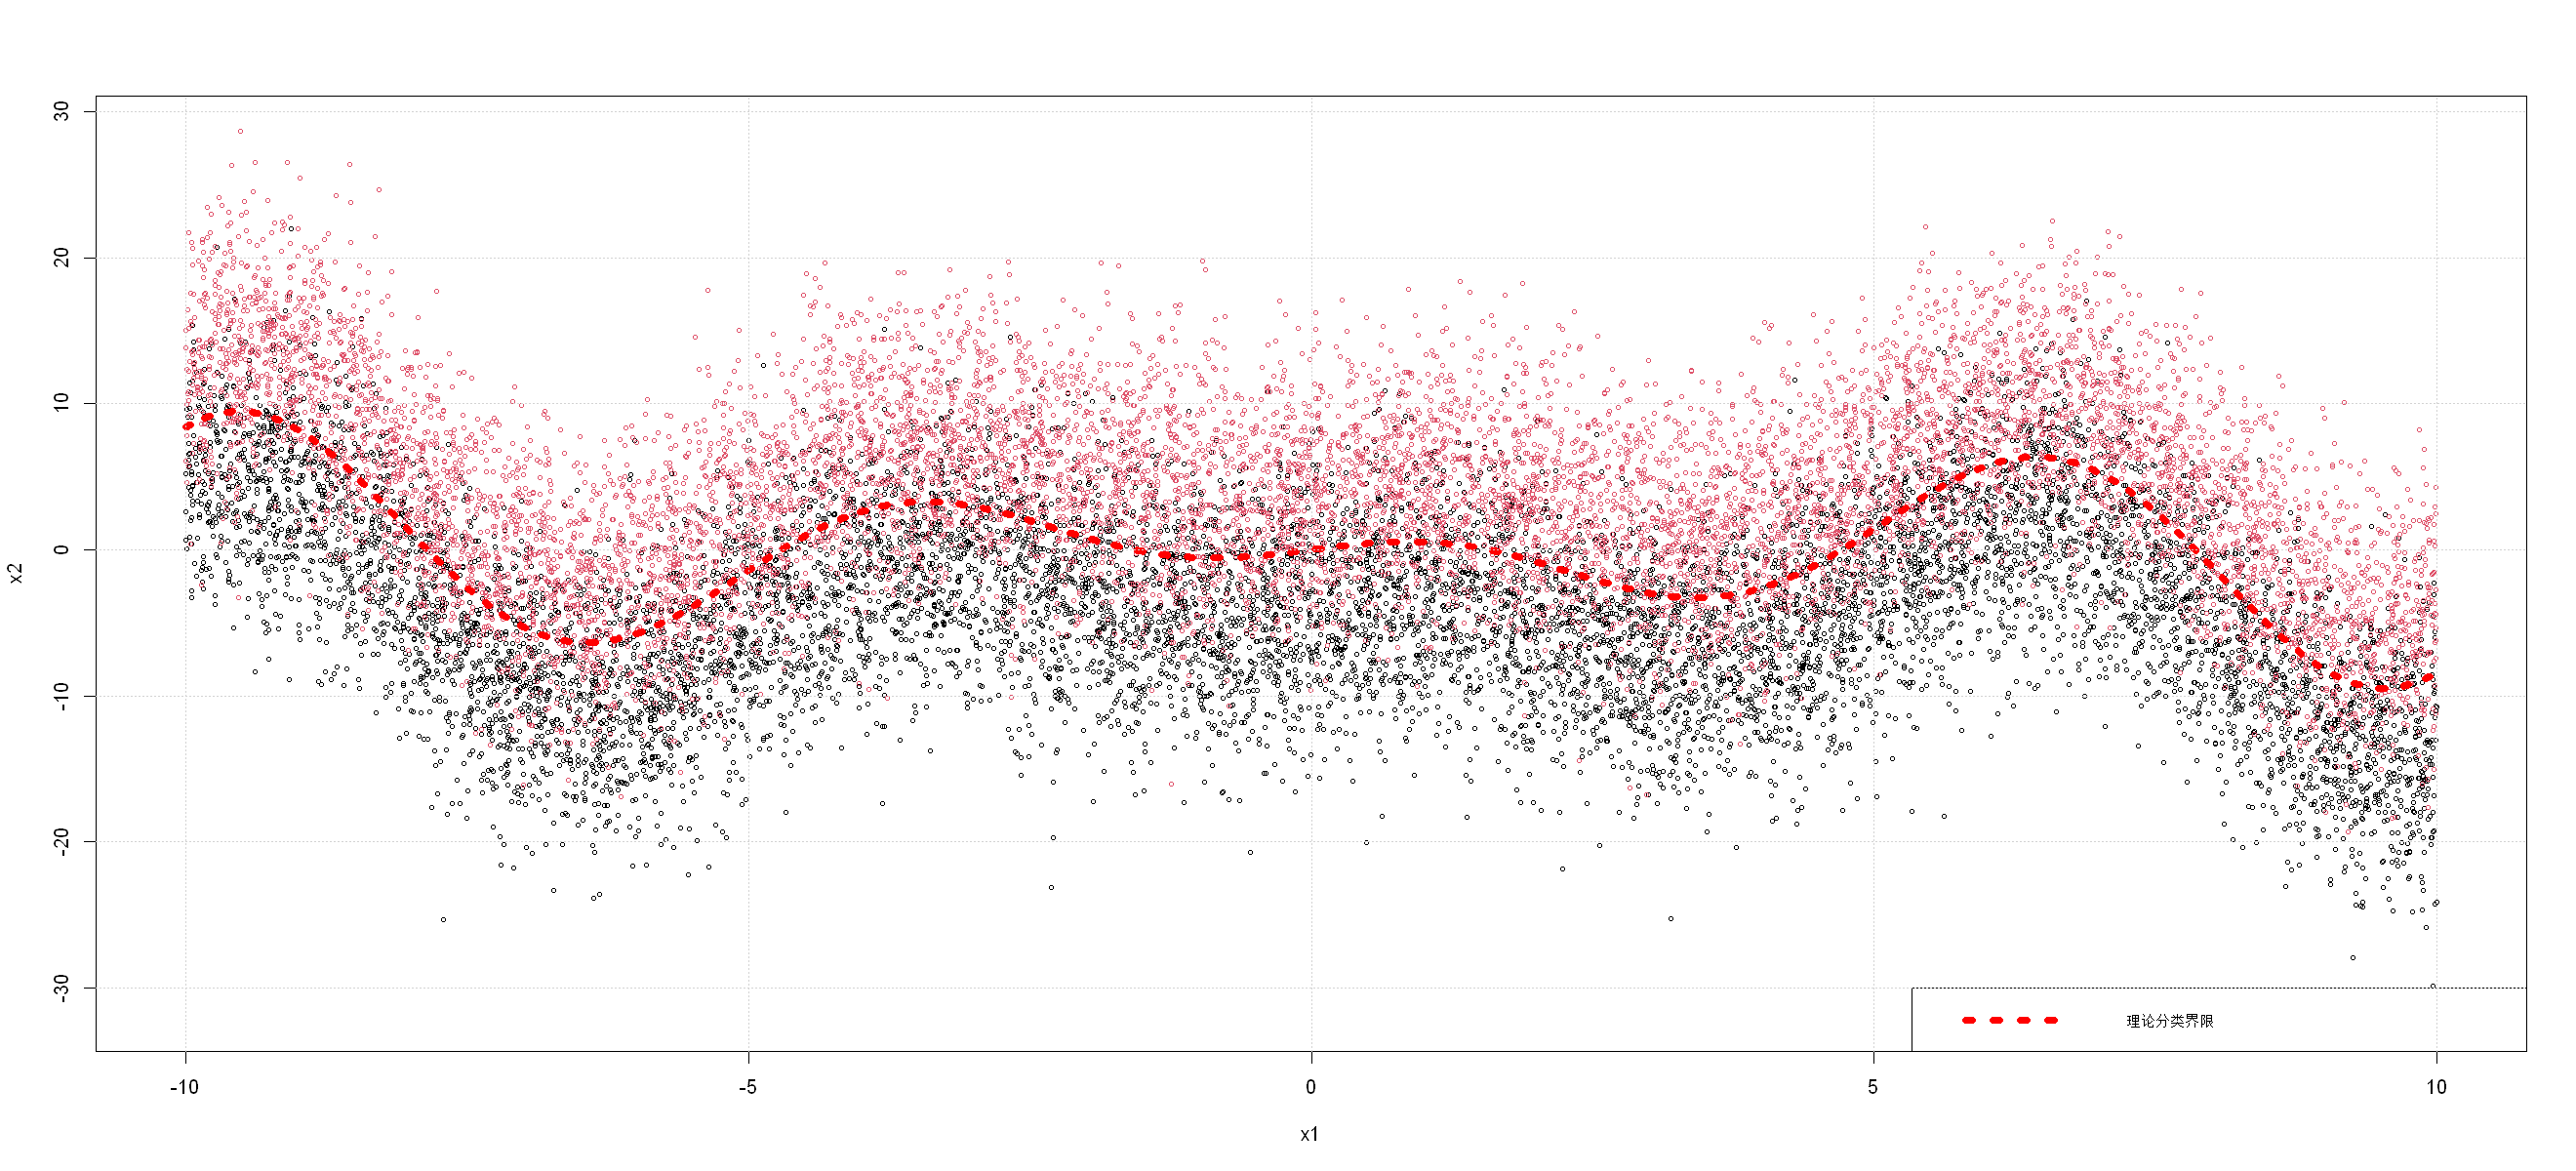

In [23]:
n <- 10000
u <- 10 # 取值范围
v <- 5  # 噪声影响强度

# --------------构建训练集cl_tr-----------------
set.seed(11)
x1 <- sort(runif(n, min = -u, max = u))
x2 <- x1 * cos(x1) + v * rnorm(n) - 4
y <- 1
d0 <- data.frame(y, x1, x2)

set.seed(22)
x1 <- sort(runif(n, min = -u, max = u))
x2 <- x1 * cos(x1) + v * rnorm(n) + 4
y <- 2
d1 <- data.frame(y, x1, x2)

cl_tr <- rbind(d0, d1)
cl_tr$y <- factor(cl_tr$y) 
plot(cl_tr$x1, cl_tr$x2, col = cl_tr$y, xlab = "x1", ylab = "x2", cex = 0.5)
x2 <- x1 * cos(x1)
lines(x1, x2, col = "red", lwd = 6, lty = 3, add = TRUE)
legend("bottomright", "理论分类界限", lwd = 6, col = "red", lty = 3, cex = 0.8)
grid()

# --------------构建测试集cl_te-----------------
set.seed(33)
x1 <- sort(runif(n, min = -u, max = u))
x2 <- x1 * cos(x1) + v * rnorm(n) - 4
y <- 1
d0 <- data.frame(y, x1, x2)

set.seed(44)
x1 <- sort(runif(n, min = -u, max = u))
x2 <- x1 * cos(x1) + v * rnorm(n) + 4
y <- 2
d1 <- data.frame(y, x1, x2)

cl_te <- rbind(d0, d1)
cl_te$y <- factor(cl_te$y) 

**勘察训练集、测试集**

In [24]:
s(cl_tr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             20000 
Number of columns          3     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts        
1 y                     0             1 FALSE          2 1: 10000, 2: 10000

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate    mean   sd    p0   p25     p50  p75 p100 hist 
1 x1                    0             1  0.0312 5.75 -10.0 -4.96  0.0592 4.97 10.0 ▇▇▇▇▇
2 x2 

In [25]:
s(cl_te)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             20000 
Number of columns          3     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts        
1 y                     0             1 FALSE          2 1: 10000, 2: 10000

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate     mean   sd    p0   p25     p50  p75 p100 hist 
1 x1                    0             1 -0.0210  5.75 -10.0 -4.95 -0.0627 4.95 10.0 ▇▇▇▇▇
2 x

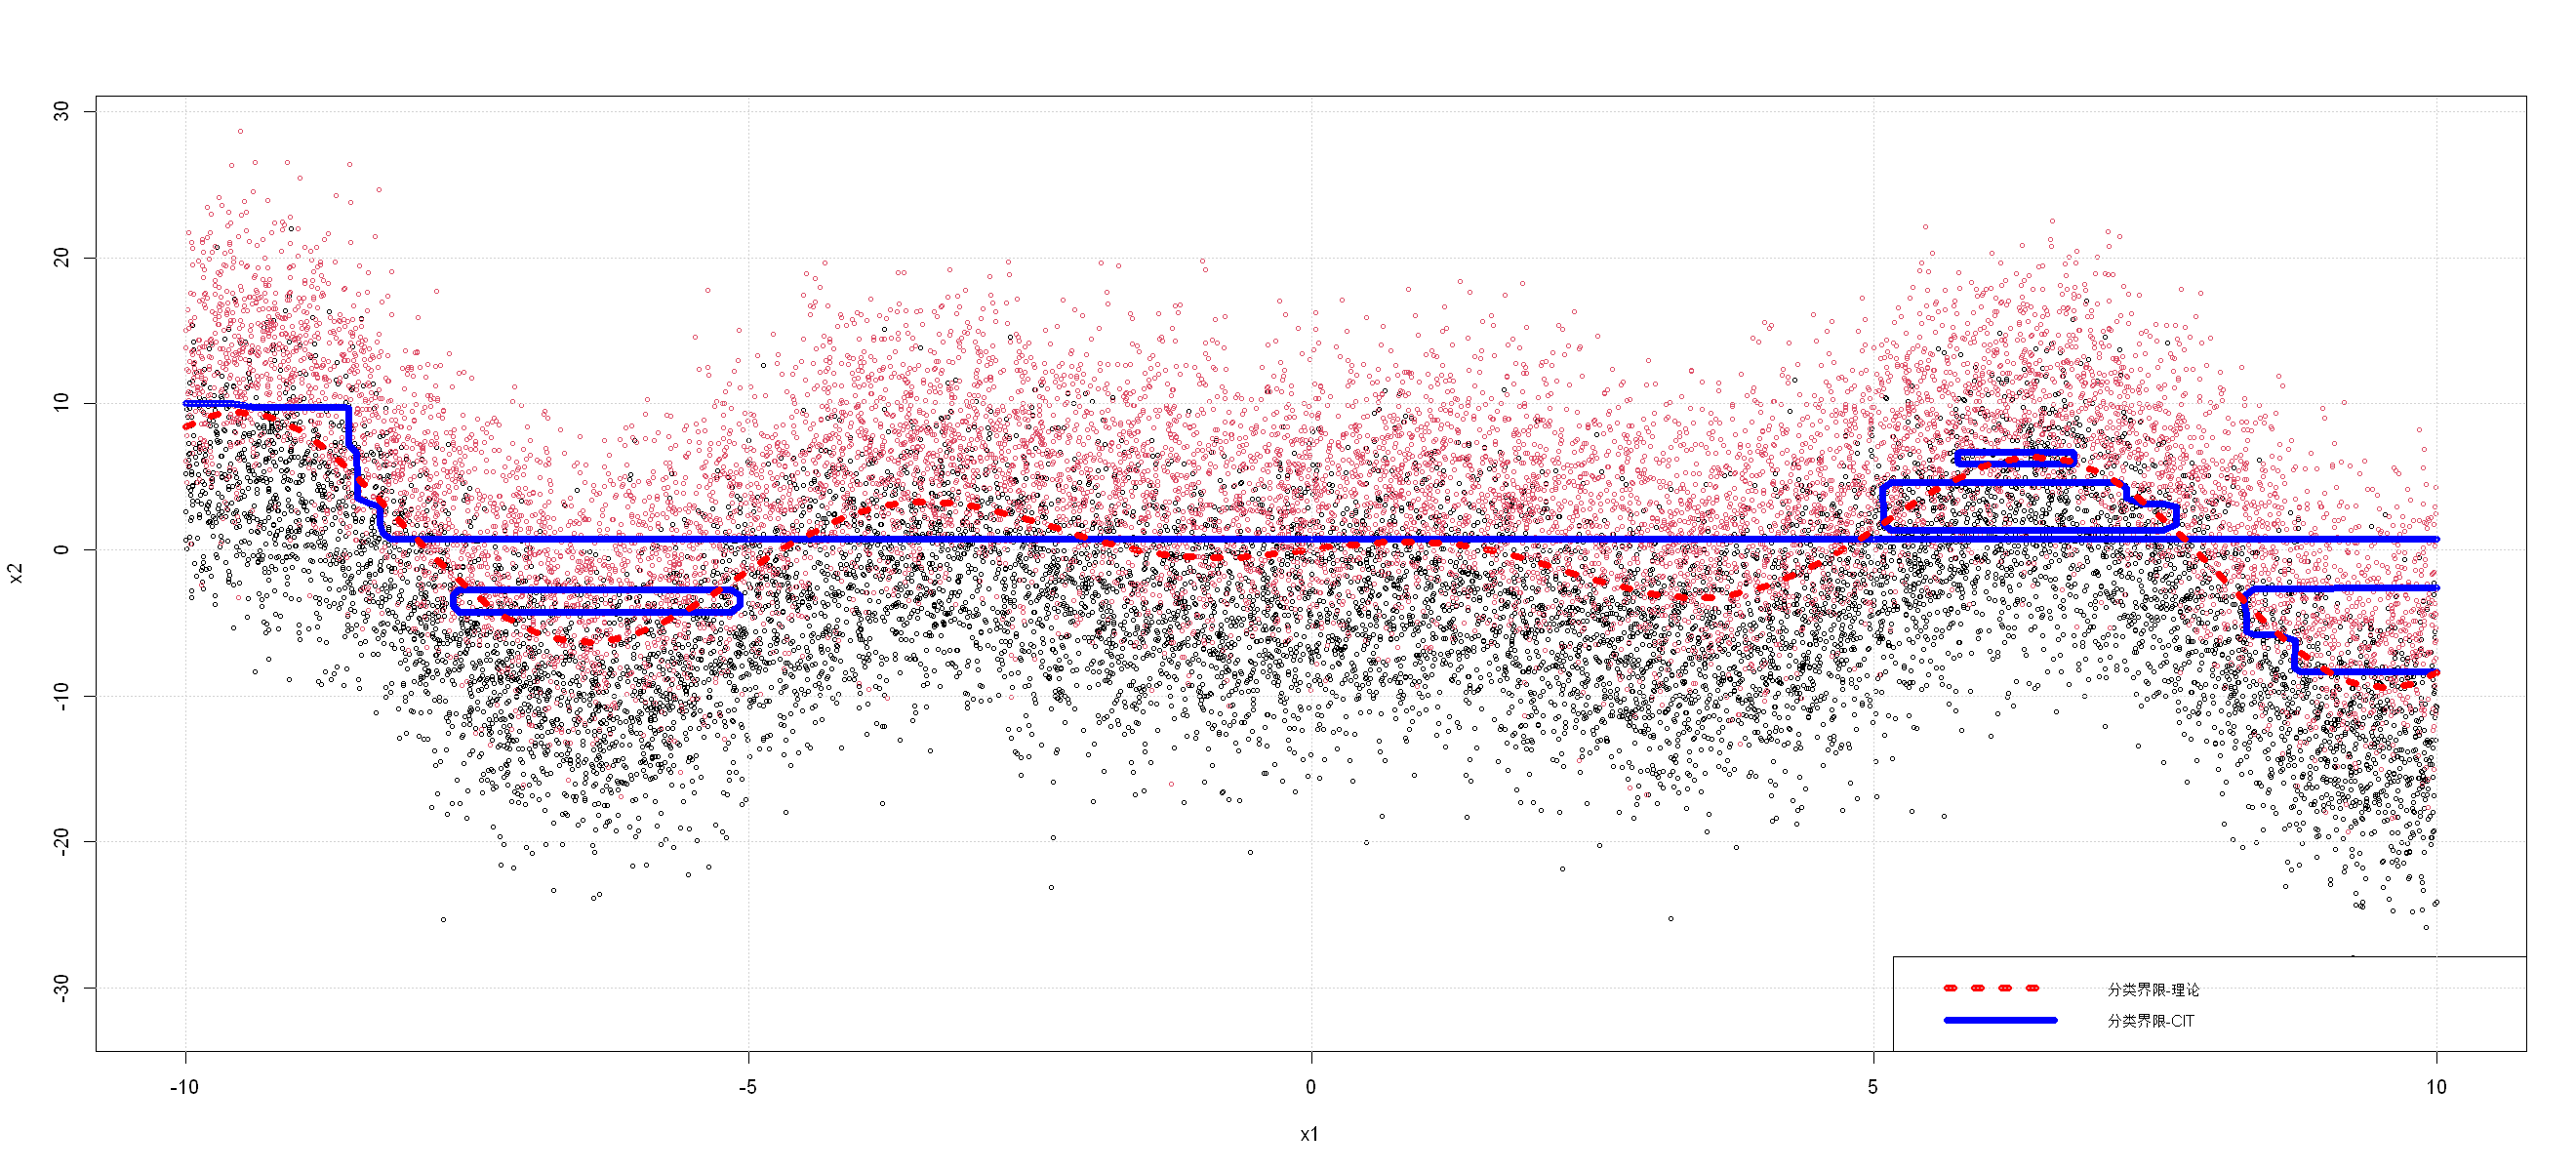

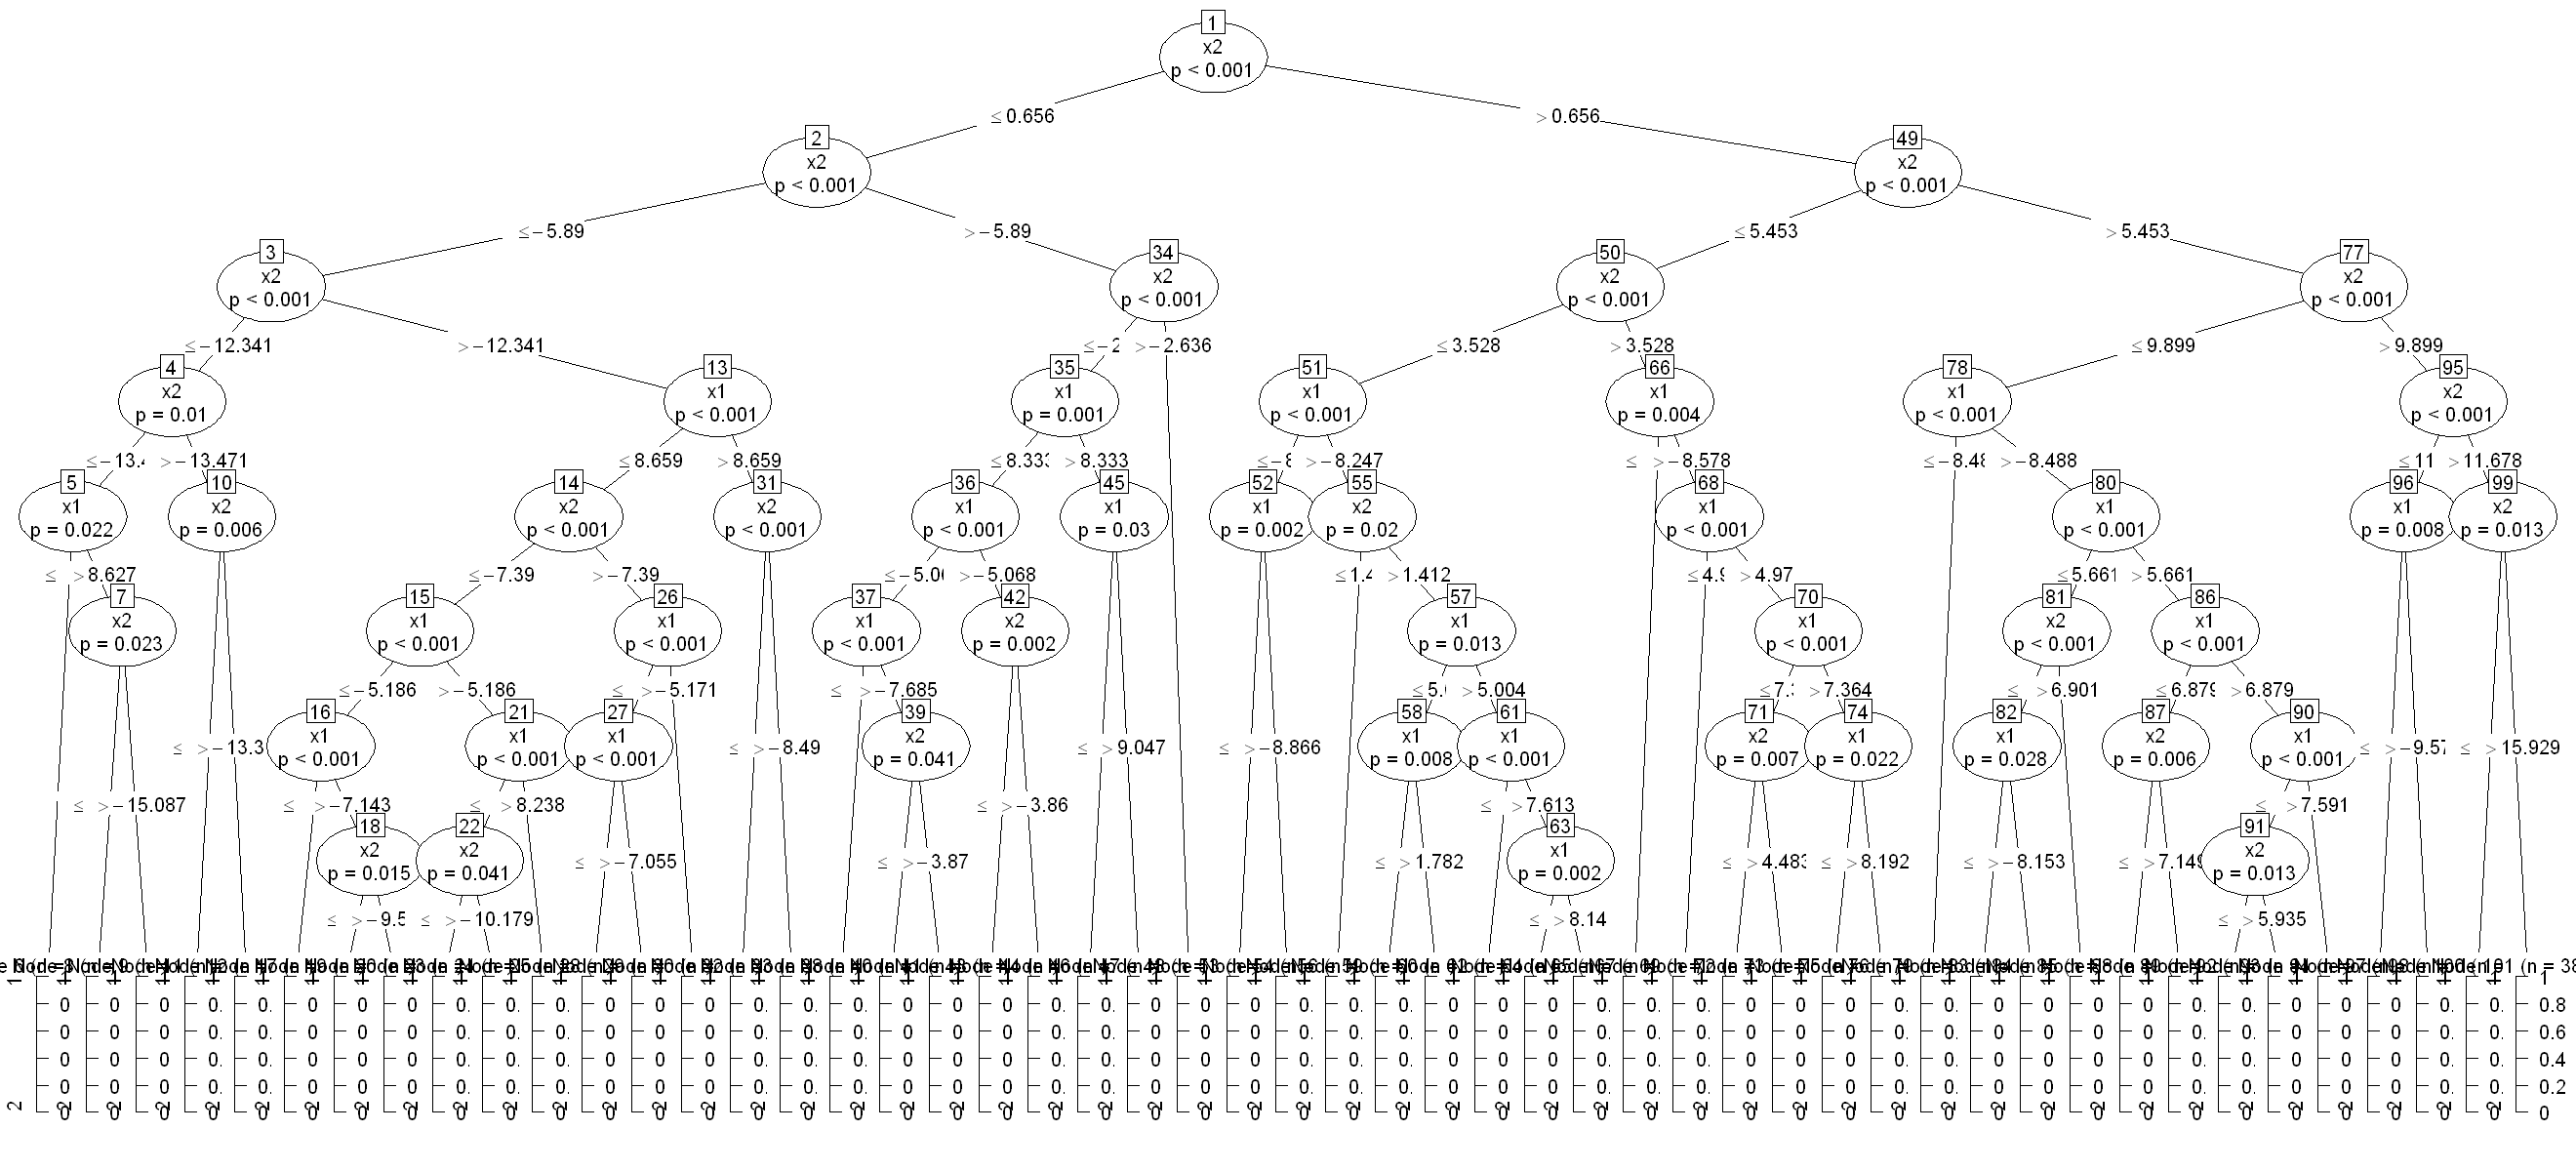

In [42]:
library(partykit)

plot(cl_tr$x1, cl_tr$x2, col = cl_tr$y, xlab = "x1", ylab = "x2", cex = 0.5)

ct_cl <- ctree(y ~ ., data = cl_tr)
x1 <- seq(min(cl_tr$x1), max(cl_tr$x1), length = 100)
x2 <- seq(min(cl_tr$x2), max(cl_tr$x2), length = 100)

pd <- function(x1, x2){
  predict(ct_cl, data.frame(x1, x2), type = "prob")[, 1]
}

z <- outer(x1, x2, FUN = pd)
contour(x1, x2, z,
  levels = 0.5, drawlabels = FALSE,
  lwd = 6, col = "blue", add = TRUE
) # 画出分类界限--置信度为0.5的等高线

x2 <- x1 * cos(x1)
lines(x1, x2,col = "red",lwd = 6, lty = 3)
legend("bottomright", c("分类界限-理论", "分类界限-CIT"), lwd = c(6, 6), col = c("red", "blue"), lty = c(3, 1),cex = 0.8)
grid()

plot(ct_cl)

In [30]:
(mean(predict(ct_cl, type = "response") != cl_tr$y))        # 训练集错误率
(mean(predict(ct_cl, cl_te, type = "response") != cl_te$y)) # 测试集集错误率

[1] 0.2407

[1] 0.24735

### 回归曲线

In [31]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(rpart,measures,treemisc,skimr)
s <- skim_tee

**构建训练集、测试集**

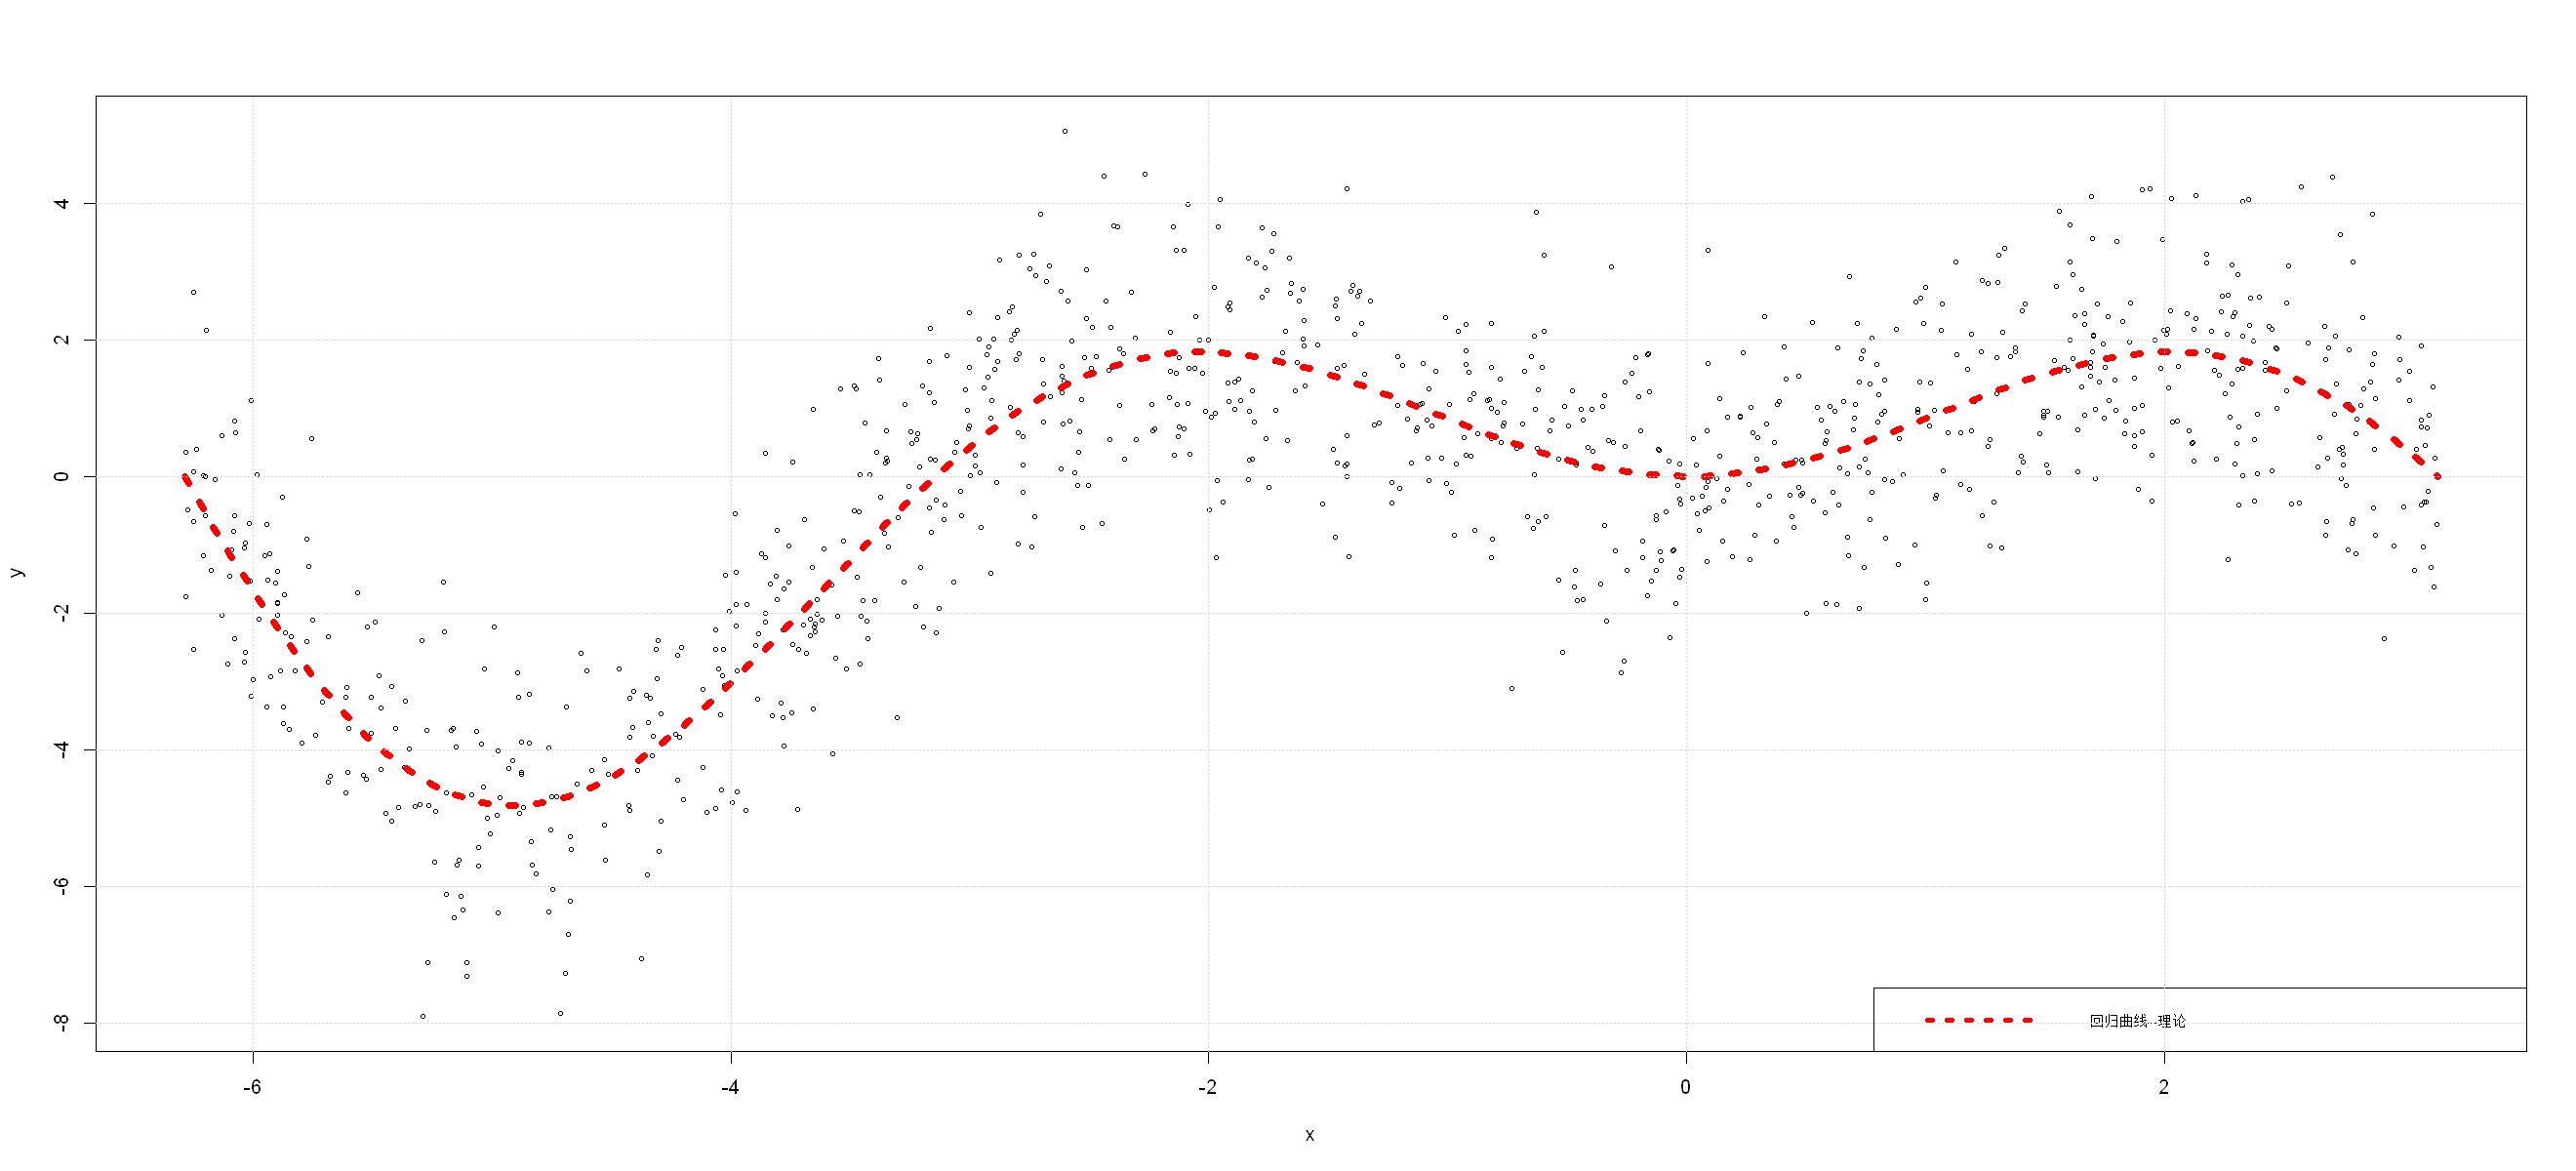

In [32]:
n <- 1000

set.seed(100)
x <- sort(runif(n, -2 * pi, pi))
y <- x * sin(x) + 1.2 * rnorm(n)
plot(x, y, cex = 0.5, xlab = "x", ylab = "y")
grid()
re_tr <- data.frame(x, y)     #训练集

curve( x * sin(x), -2 * pi, pi, bty = "l", lwd = 6, col = "red", lty = 3, add = TRUE)

legend("bottomright", "回归曲线--理论", lwd = 4, col = "red", lty = 3, cex = 0.8)
grid()

set.seed(200)
x <- runif(n, -2 * pi, pi)
y <- x * sin(x) + 1.2 * rnorm(n)
re_te <- data.frame(x, y)       #测试集

**勘察训练集、测试集**

In [33]:
s(re_tr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          2     
_______________________          
Column type frequency:           
  numeric                  2     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean   sd    p0   p25    p50   p75 p100 hist 
1 x                     0             1 -1.40  2.71 -6.28 -3.64 -1.41  0.916 3.14 ▆▇▇▇▇
2 y                     0             1 -0.125 2.34 -7.89 -1.45  0.355 1.55  5.05 ▁▂▅▇▂


In [34]:
s(re_te)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          2     
_______________________          
Column type frequency:           
  numeric                  2     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean   sd    p0   p25    p50   p75 p100 hist 
1 x                     0             1 -1.59  2.62 -6.28 -3.79 -1.50  0.559 3.14 ▇▇▇▇▆
2 y                     0             1 -0.298 2.51 -8.09 -1.79  0.337 1.48  6.16 ▁▃▆▇▁


**CIT的回归曲线**

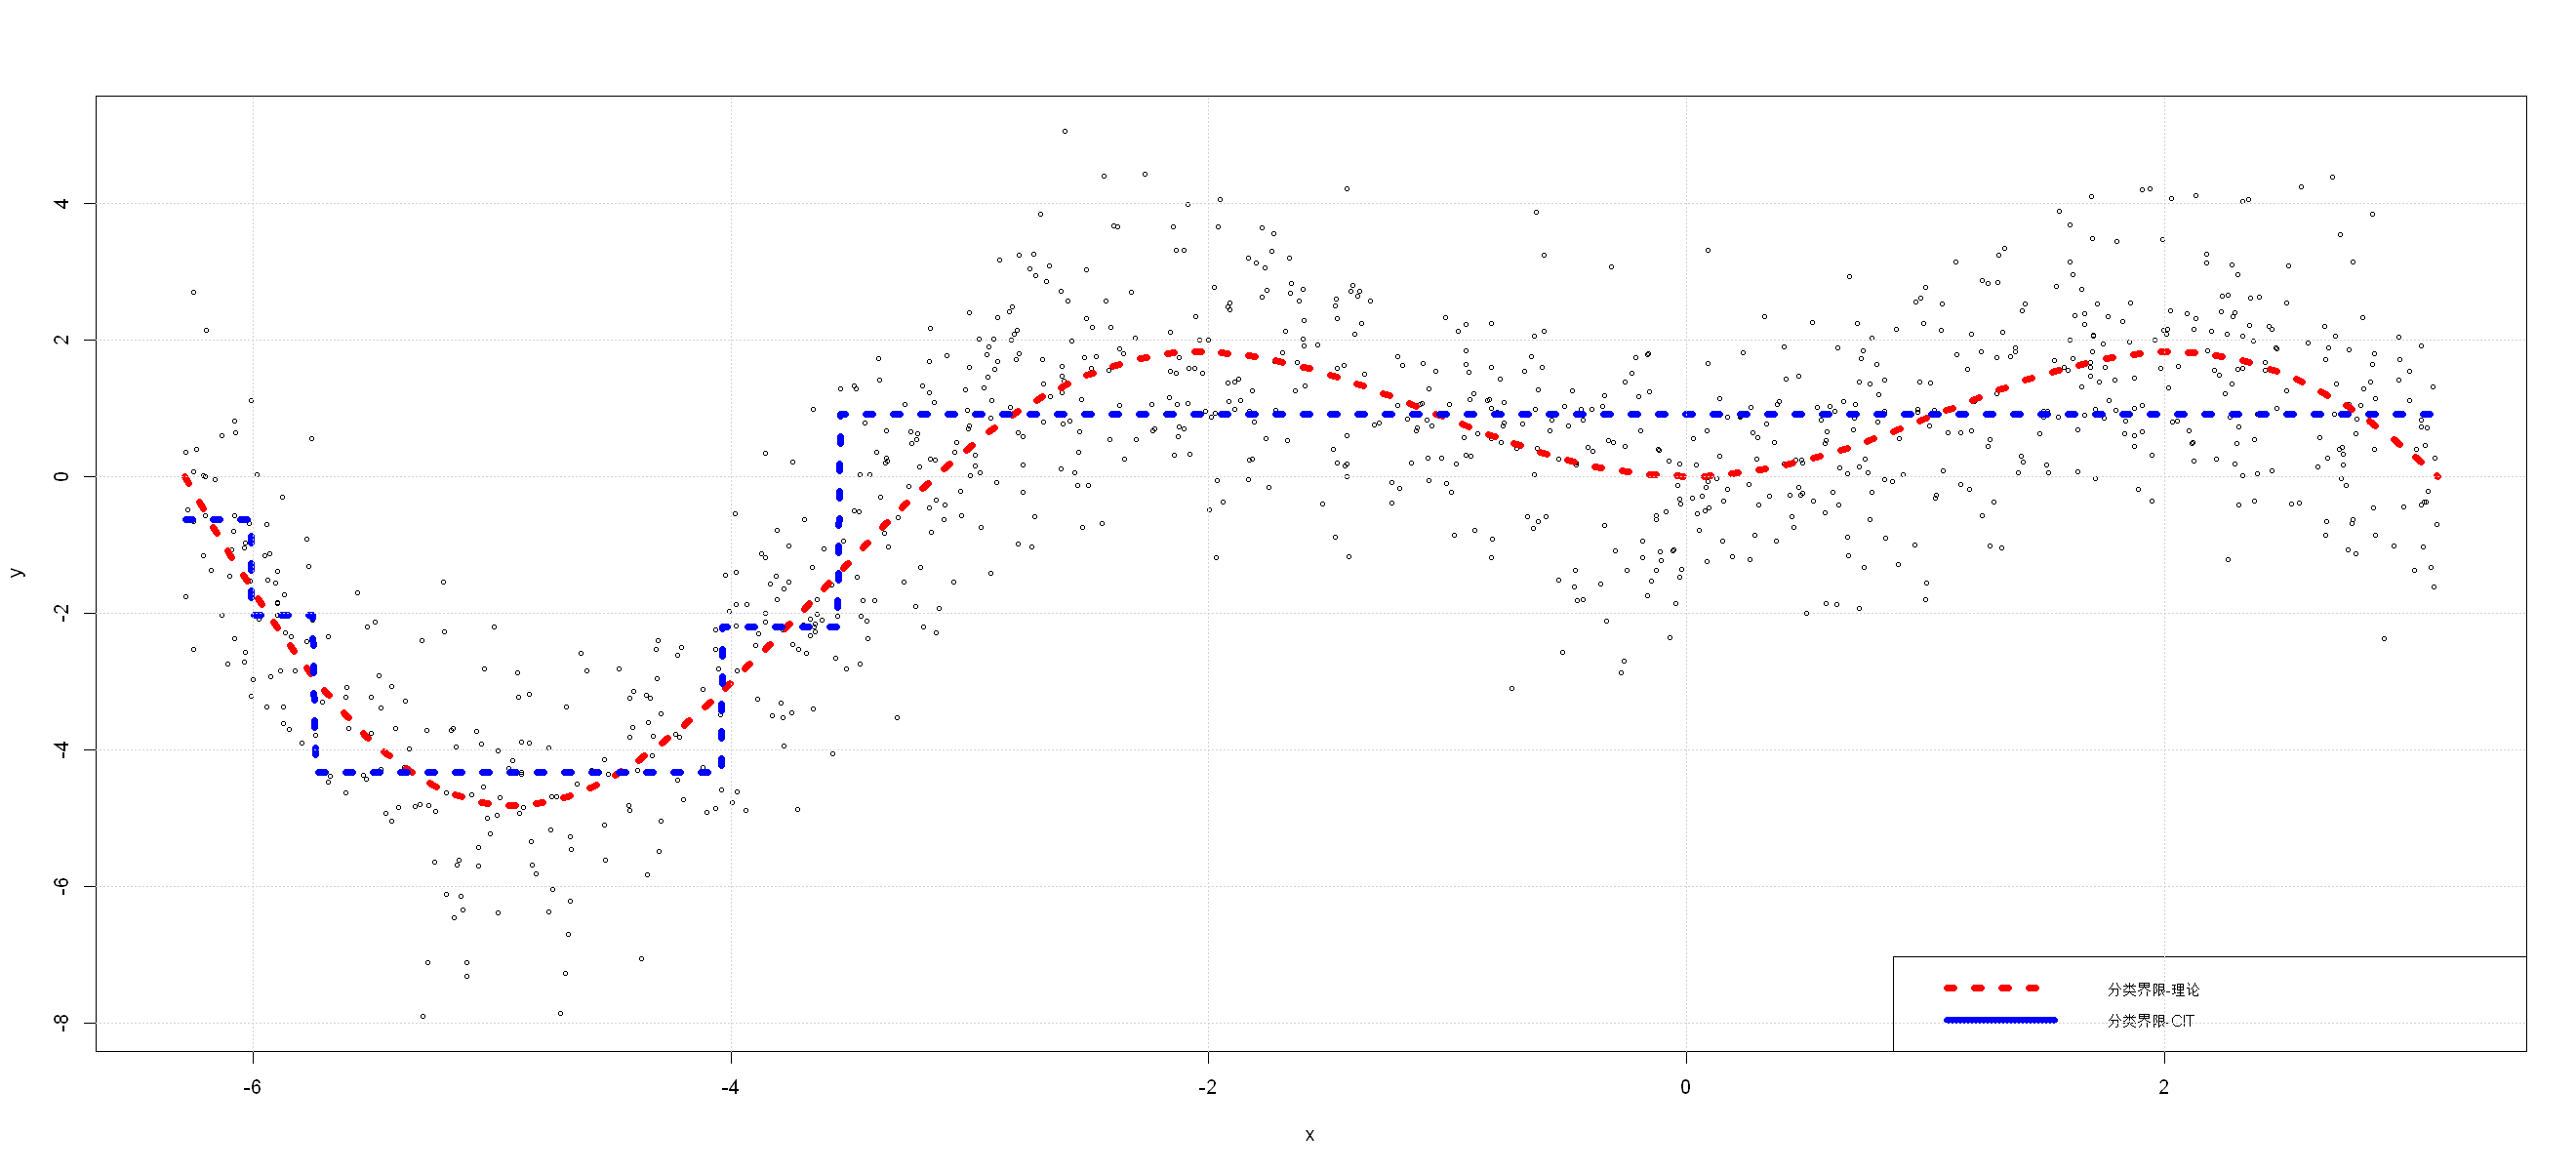

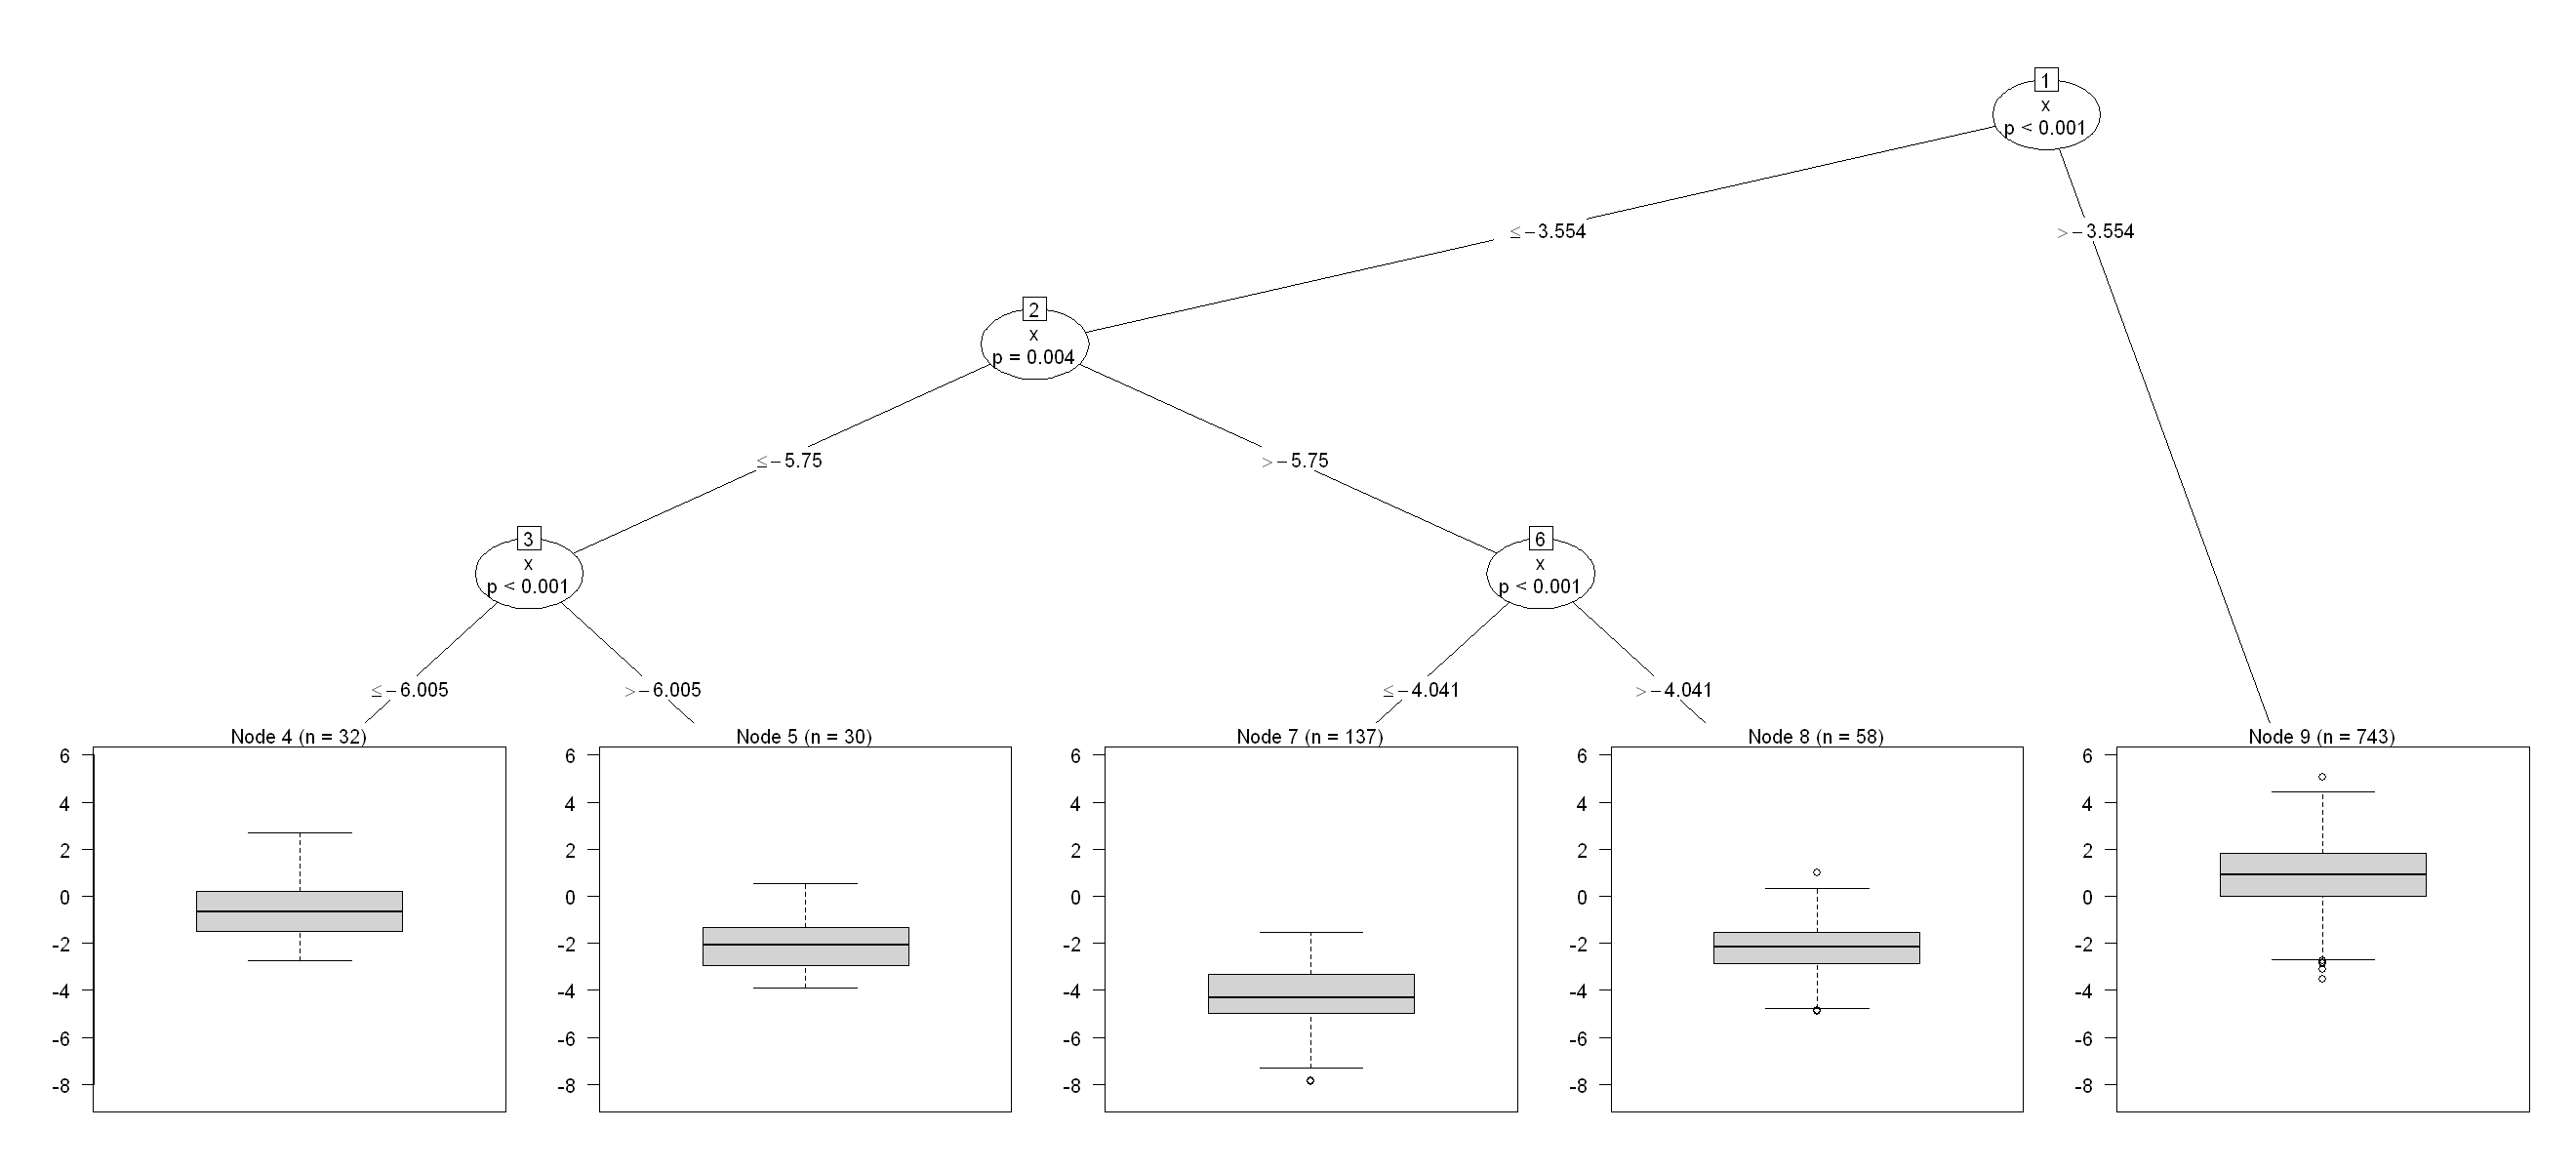

In [41]:
ct_re <- ctree(y ~ ., data = re_tr)

plot(re_tr$x, re_tr$y, xlab = "x", ylab = "y", cex = 0.5)
curve( x * sin(x), -2 * pi, pi, bty = "l", lwd = 6, col = "red", lty = 3, add = TRUE)
lines(re_tr$x, predict(ct_re, type = "response"), col = "blue", lwd = 6, lty = 3)
legend("bottomright", c("分类界限-理论", "分类界限-CIT"), lwd = c(6, 6), col = c("red", "blue"), lty = c(3, 1),cex = 0.8)
grid()

plot(ct_re)

In [40]:
(RMSE(re_tr$y, predict(ct_re, re_tr, type = "response")))  #训练集的RMSE
(RMSE(re_te$y, predict(ct_re, re_te, type = "response")))    #测试集的RMSE

[1] 1.374951

[1] 1.399771

## 算法详解

以airquality问题根节点分枝属性和分枝点的选定为例：

In [15]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(partykit, rpart, skimr, coin)
s <- skim_tee

aq <- datasets::airquality
aq <- na.omit(aq)   #删除有缺失值的行
s(aq)


── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             111   
Number of columns          6     
_______________________          
Column type frequency:           
  numeric                  6     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean    sd   p0   p25   p50   p75  p100 hist 
1 Ozone                 0             1  42.1  33.3   1    18    31    62   168   ▇▃▂▁▁
2 Solar.R               0             1 185.   91.2   7   114.  207   256.  334   ▅▃▅▇▅
3 Wind                  0             1   9.94  3.56  2.3   7.4   9.7  11.5  20.7 ▂▇▇▃▁
4 Temp                  0             1  77.8   9.53 57    71    79    84.5  97   ▃▅▇▆▃
5 Month                 0             1   7.22  1.47  5     6     7    

In [16]:
(ctree(Ozone ~ ., data = aq))


Model formula:
Ozone ~ Solar.R + Wind + Temp + Month + Day

Fitted party:
[1] root
|   [2] Temp <= 82
|   |   [3] Wind <= 6.9: 61.000 (n = 9, err = 19322.0)
|   |   [4] Wind > 6.9
|   |   |   [5] Temp <= 77: 18.277 (n = 47, err = 3863.4)
|   |   |   [6] Temp > 77: 31.143 (n = 21, err = 4620.6)
|   [7] Temp > 82
|   |   [8] Wind <= 10.3: 84.074 (n = 27, err = 12525.9)
|   |   [9] Wind > 10.3: 48.714 (n = 7, err = 1183.4)

Number of inner nodes:    4
Number of terminal nodes: 5

可见CIT根节点以Temp作为分枝属性，以“82”作为其分枝点。以下详细分析其选定过程：

1.确定分枝属性

In [17]:
xnames <- setdiff(names(aq), "Ozone")     # feature names
res <- sapply(xnames, FUN = function(x) {
  it <- independence_test(aq[["Ozone"]] ~ aq[[x]])
  "pval" <- pvalue(it)
})
t(res)      # print transpose of results (nicer printing)
which.min(res)


Solar.R,Wind,Temp,Month,Day
0.0002587518,1.328105e-10,2.364775e-13,0.1339794,0.956592


Temp 
   3

可见属性Temp的p值最小且小于默认显著性水平0.05，所以选定Temp作为根节点分枝属性

2.选定分枝点

In [18]:
#获取分枝备选点向量
sp <- sort(unique(aq$Temp))
sp <- sp[-1]
sp <- head(sp, -1)

#依次尝试备选点，遴选出统计量最大的作为分枝点
st <- sapply(sp, function(split) statistic(independence_test(Ozone ~ factor(Temp <= split), data = aq)))
sp[which.max(st)]

[1] 82

当Tem=82时，独立性检验的统计量最大，所以以"82"作为Tem的分枝点。

## 分类

### 代价不敏感
abalone数据集来自4177只鲍鱼，自变量包括type(公、母、幼)、LongestShell 、Diameter、 Height和几种重量(WholeWeight、ShuckedWeight、VisceraWeightShellWeight)，因变量是Rings(外壳上的环数)。

将abalone 数据集的Rings值改造成"L"、 "H"二个数量大致相同的类别，当前的问题是根据一系列自变量，判断Rings类别，自变量混合取值--<font color=Red>既有离散取值，也有连续取值</font>。　　

In [19]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(partykit,AppliedPredictiveModeling,skimr,coin)
s <- skim_tee

**导入、改造、勘察数据**

In [20]:
data(abalone)
ab <- abalone
ab$Rings <- factor(ab$Rings> 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 2096, H: 2081         

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

In [7]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
tr_ab <- ab[I, ]
te_ab <- ab[-I, ]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1044, H: 1044      

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

可见Rings的L类和H类数量平衡

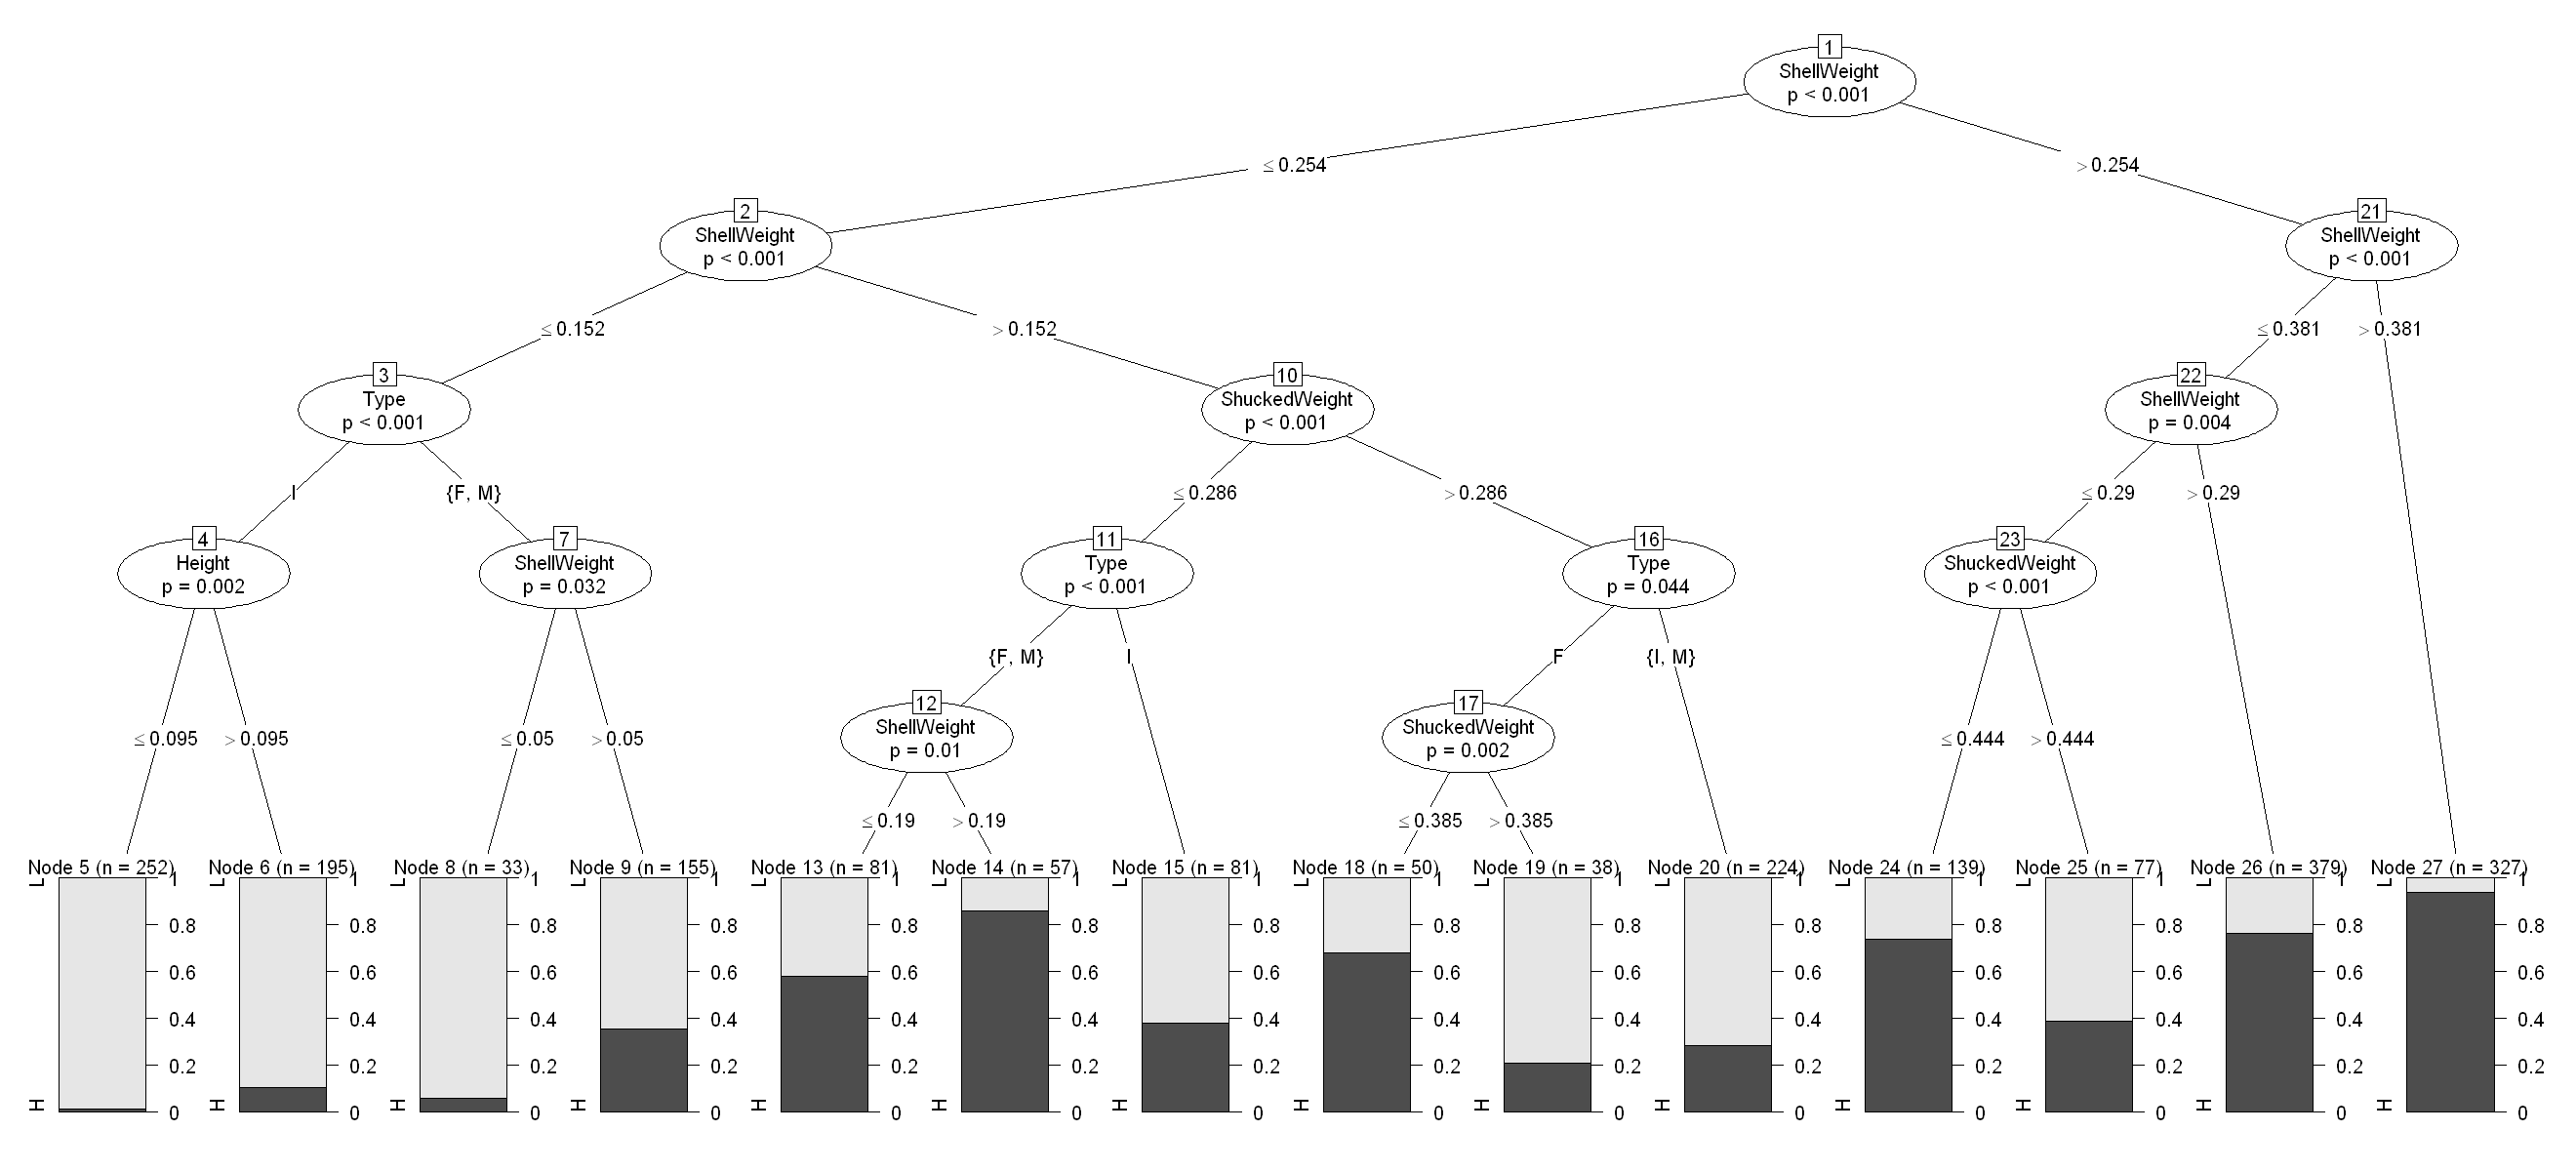

In [8]:
ct_ab <- ctree(Rings ~ ., data = tr_ab) 
plot(ct_ab) 


In [9]:
mean(predict(ct_ab) != tr_ab$Rings)
mean(predict(ct_ab, te_ab ) != te_ab$Rings)

[1] 0.2006705

[1] 0.2178076

此例优于rpart的性能 参见 https://github.com/A-Pai/Tree-Based-Learning-Methods-in-R/blob/main/decision%20tree/1-rpart.ipynb


In [14]:
(ctree_control())    #CIT控制参数默认值

$criterion
[1] "p.value"

$logmincriterion
[1] -0.05129329

$minsplit
[1] 20

$minbucket
[1] 7

$minprob
[1] 0.01

$maxvar
[1] Inf

$stump
[1] FALSE

$nmax
 yx   z 
Inf Inf 

$lookahead
[1] FALSE

$mtry
[1] Inf

$maxdepth
[1] Inf

$multiway
[1] FALSE

$splittry
[1] 2

$maxsurrogate
[1] 0

$numsurrogate
[1] FALSE

$majority
[1] FALSE

$caseweights
[1] TRUE

$applyfun
function (X, FUN, ...) 
{
    FUN <- match.fun(FUN)
    if (!is.vector(X) || is.object(X)) 
        X <- as.list(X)
    .Internal(lapply(X, FUN))
}
<bytecode: 0x000001dc3ea73dd8>
<environment: namespace:base>

$saveinfo
[1] TRUE

$bonferroni
[1] TRUE

$update
NULL

$selectfun
function (model, trafo, data, subset, weights, whichvar, ctrl) 
{
    args <- list(...)
    ctrl[names(args)] <- args
    .select(model, trafo, data, subset, weights, whichvar, ctrl, 
        FUN = .ctree_test)
}
<bytecode: 0x000001dc4d54d4e0>
<environment: 0x000001dc57a39040>

$splitfun
function (model, trafo, data, subset, weights, whichvar, ctrl) 
{

### 代价敏感

将abalone数据集改造成非平衡(代价敏感问题常出现于非平衡数据集)，假定将Rings的“H”类判为“L”代价为5，将“L”类判为“H”代价为1

In [21]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(party)
p_load(AppliedPredictiveModeling)
p_load(skimr)
s <- skim_tee

In [22]:
data(abalone)
s(abalone)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  8     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50    p75   p100 hist 
1 LongestShell          0             1 0.524 0.120  0.075  0.45   0.545  0.

In [24]:
abi <- abalone
abi$Rings <- factor((abi$Rings) > 12, labels = c("L", "H")) # 处理成占比悬殊的二类
s(abi)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 3484, H: 693          

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

In [25]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(abi), nrow(abi) * 0.5)
tr_abi <- abi[I, ]
te_abi <- abi[-I, ]
table(tr_abi$Rings)
table(te_abi$Rings)


   L    H 
1737  351 


   L    H 
1747  342 

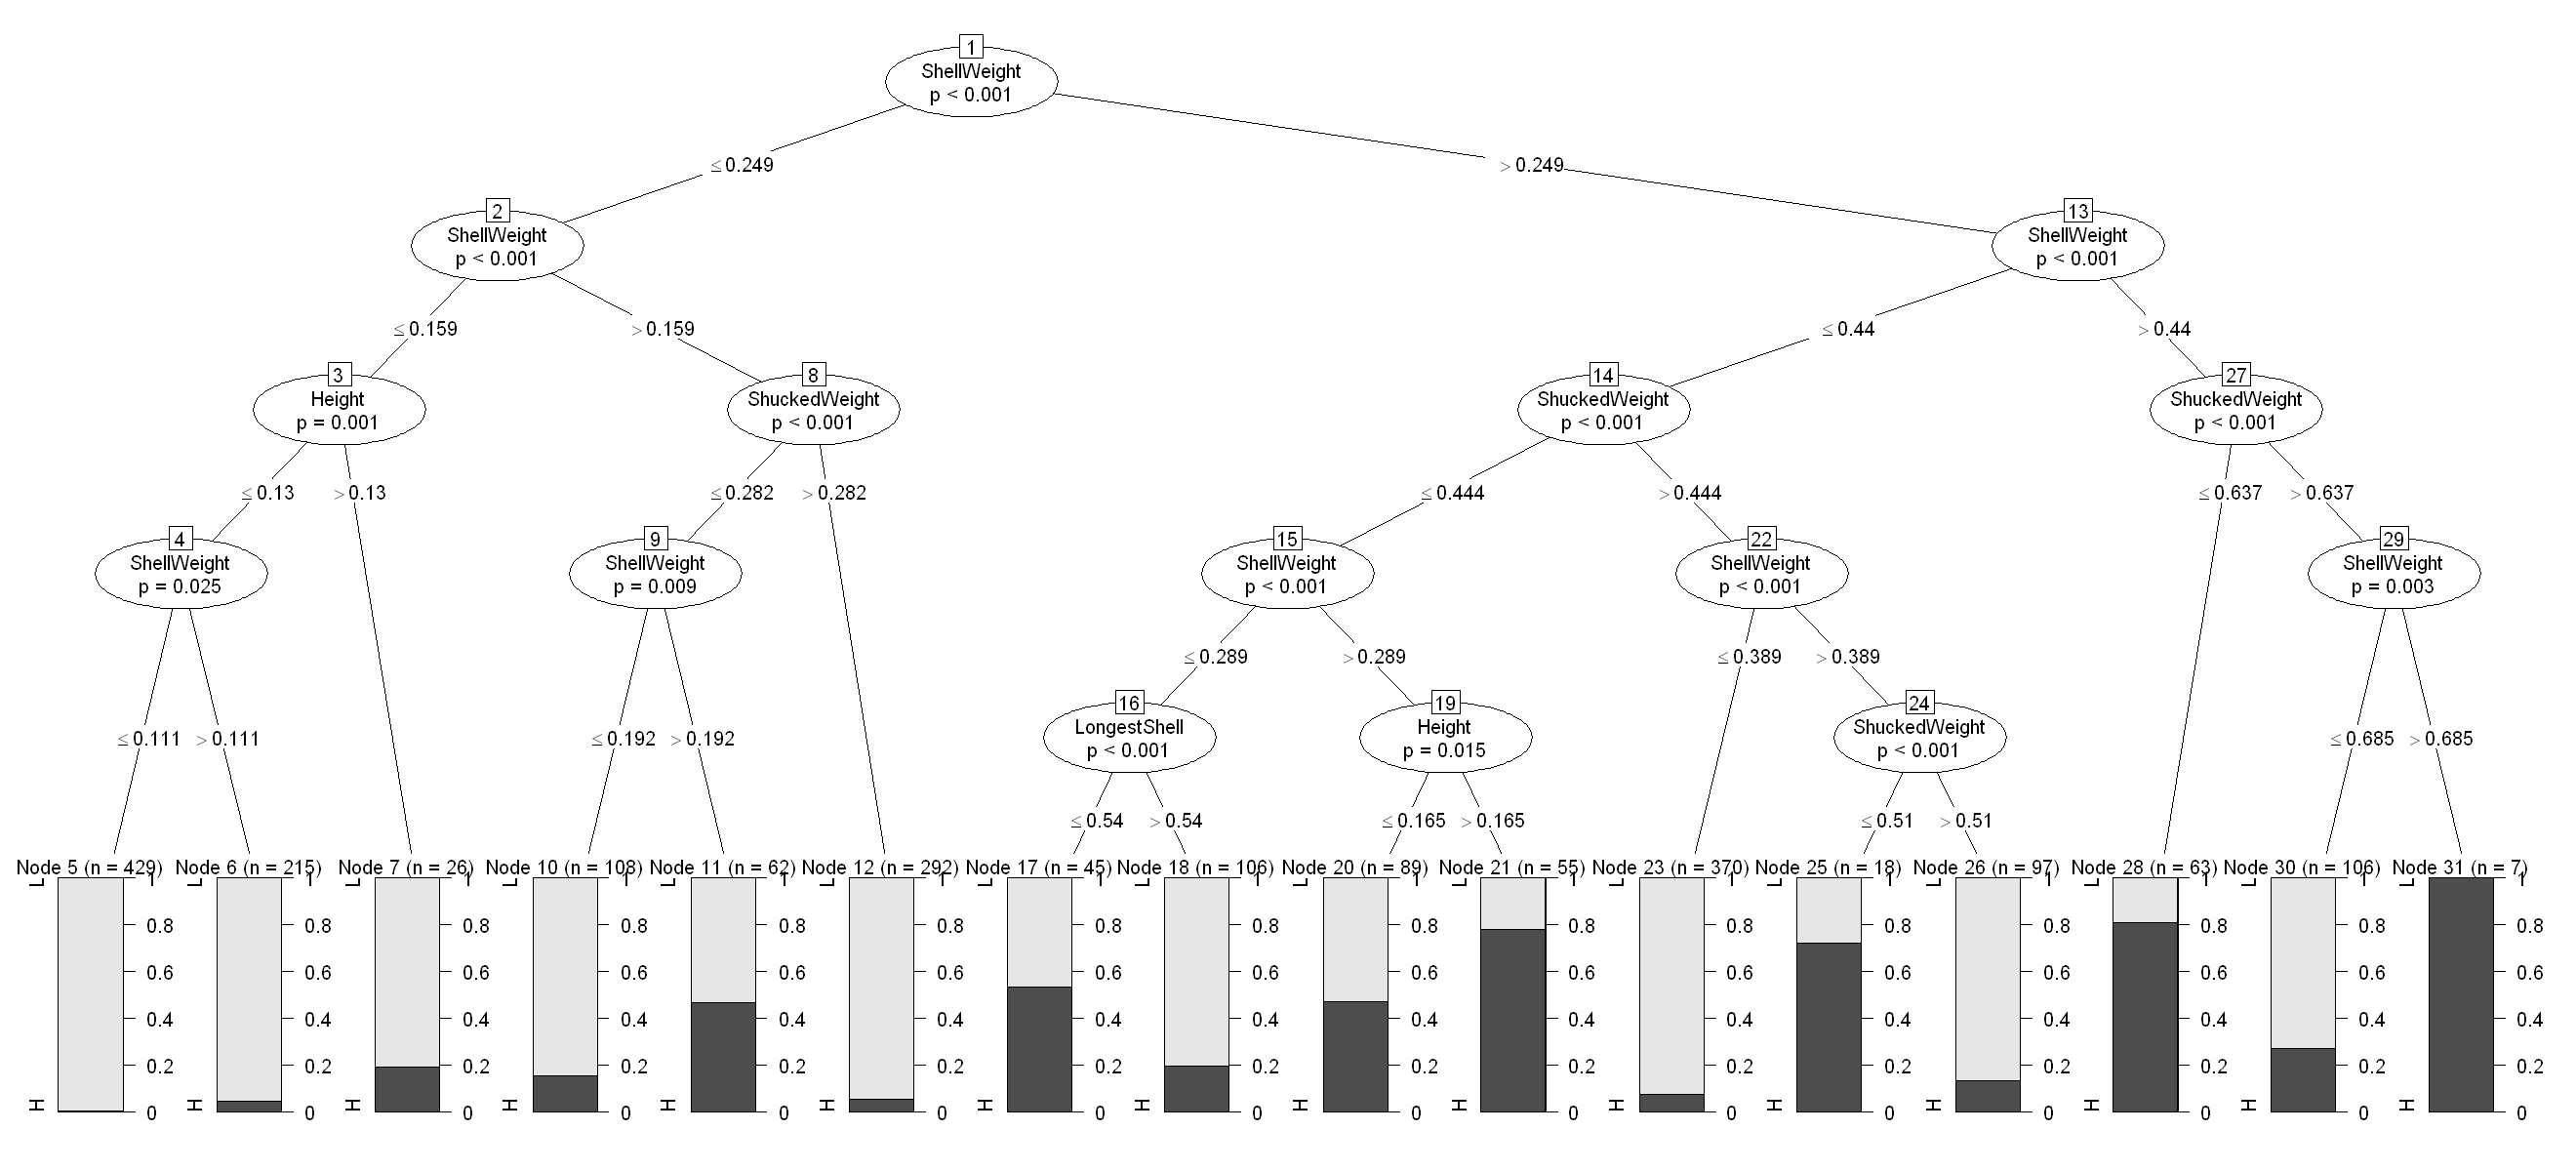

In [27]:
ct_abi <- ctree(Rings ~ ., data = tr_abi) 
plot(ct_abi) 

In [32]:
table(tr_abi$Rings, predict(ct_abi))
table(te_abi$Rings, predict(ct_abi, te_abi))
#可见ct_abi倾向于将"H"类样例判别为"L"类

   
       L    H
  L 1687   50
  H  213  138

   
       L    H
  L 1687   60
  H  233  109

测试集总损失

In [57]:
sum((te_abi$Rings == "L") * (predict(ct_abi, te_abi) == "H")) * 1 +
  sum((te_abi$Rings == "H") * (predict(ct_abi, te_abi) == "L")) * 5

[1] 1225

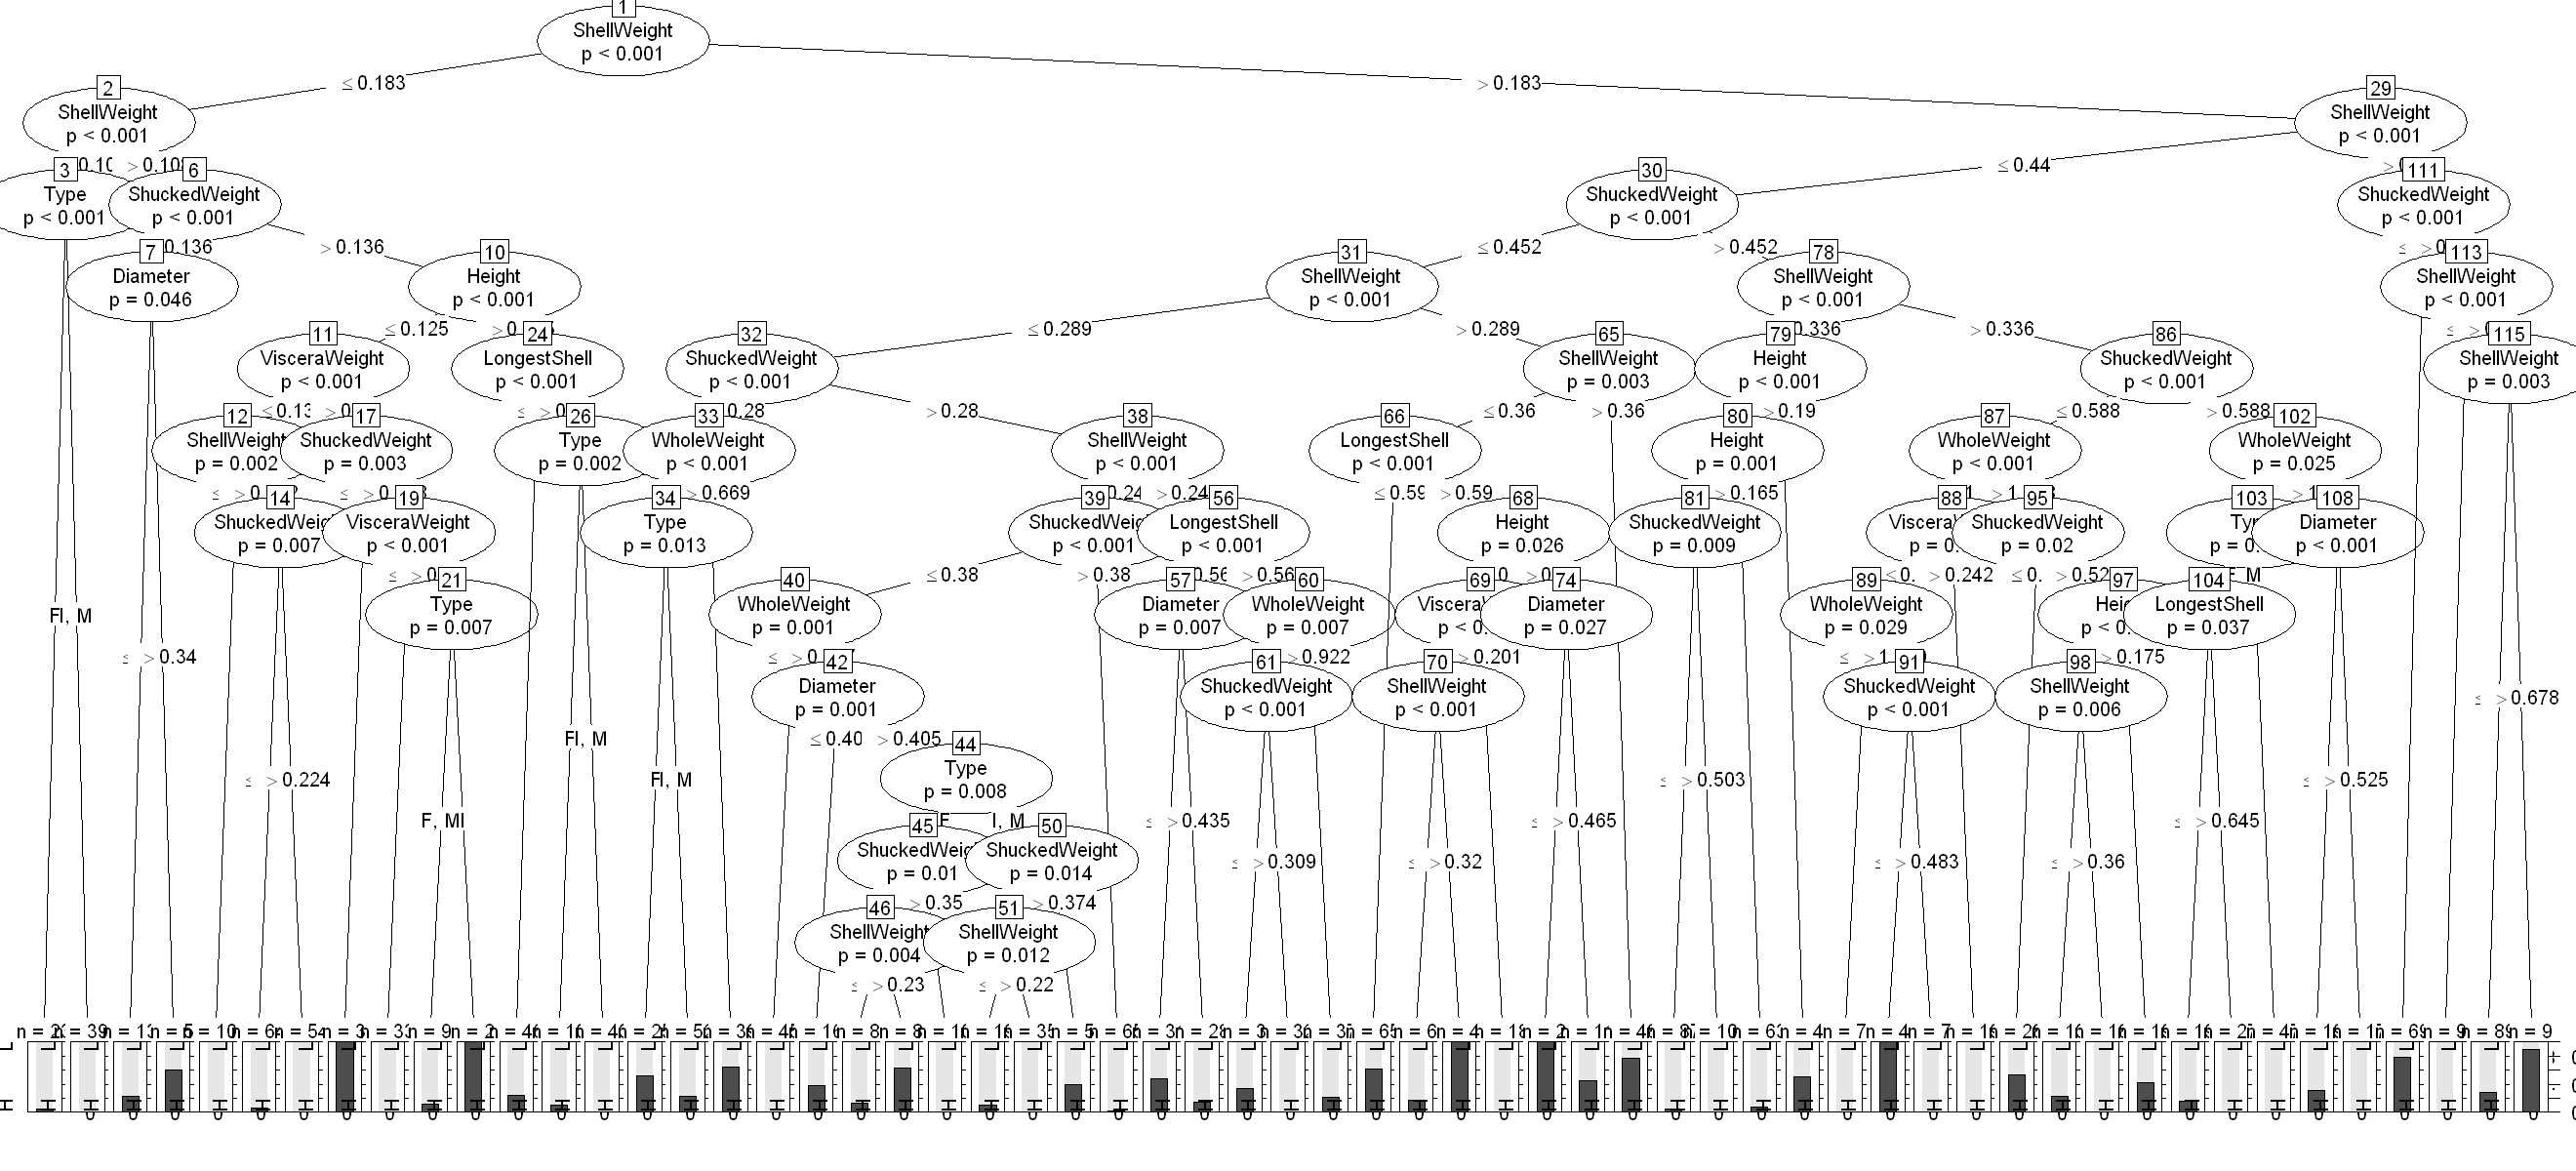

In [54]:
w = ifelse(tr_abi$Rings == "H",5,1)   #L判为H损失1，H判为L损失4，所以将H类的权重由1改为4
ct_abiw <- ctree(Rings ~ ., data = tr_abi, weights = w) 
plot(ct_abiw, terminal_panel=node_barplot(ct_abiw,ylines=0.2,id=F,gap=0.5))

In [55]:
# 测试集总损失
sum((te_abi$Rings == "L") * (predict(ct_abiw, te_abi) == "H")) * 1 +
  sum((te_abi$Rings == "H") * (predict(ct_abiw, te_abi) == "L")) * 5

[1] 899

In [58]:
table(tr_abi$Rings, predict(ct_abiw))
table(te_abi$Rings, predict(ct_abiw, te_abi))
#可见ct_abiw不再倾向于将"H"类样例判别为"L"类

   
       L    H
  L 1390  347
  H   29  322

   
       L    H
  L 1318  429
  H   94  248

## 回归

### 自变量混合取值

　　根据一系列属性推测abalone的年龄值：

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(rpart,partykit,measures,AppliedPredictiveModeling)
p_load(skimr)
s <- skim_tee

In [2]:
data(abalone)
ab <- abalone
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  8     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50    p75   p100 hist 
1 LongestShell          0             1 0.524 0.120  0.075  0.45   0.545  0.

In [3]:
#将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab),nrow(ab)*0.5)
tr_ab <- ab[I,]
te_ab <- ab[-I,]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  8     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50    p75   p100 hist 
1 LongestShell          0             1 0.525 0.120  0.13   0.45   0.545  0.615  0

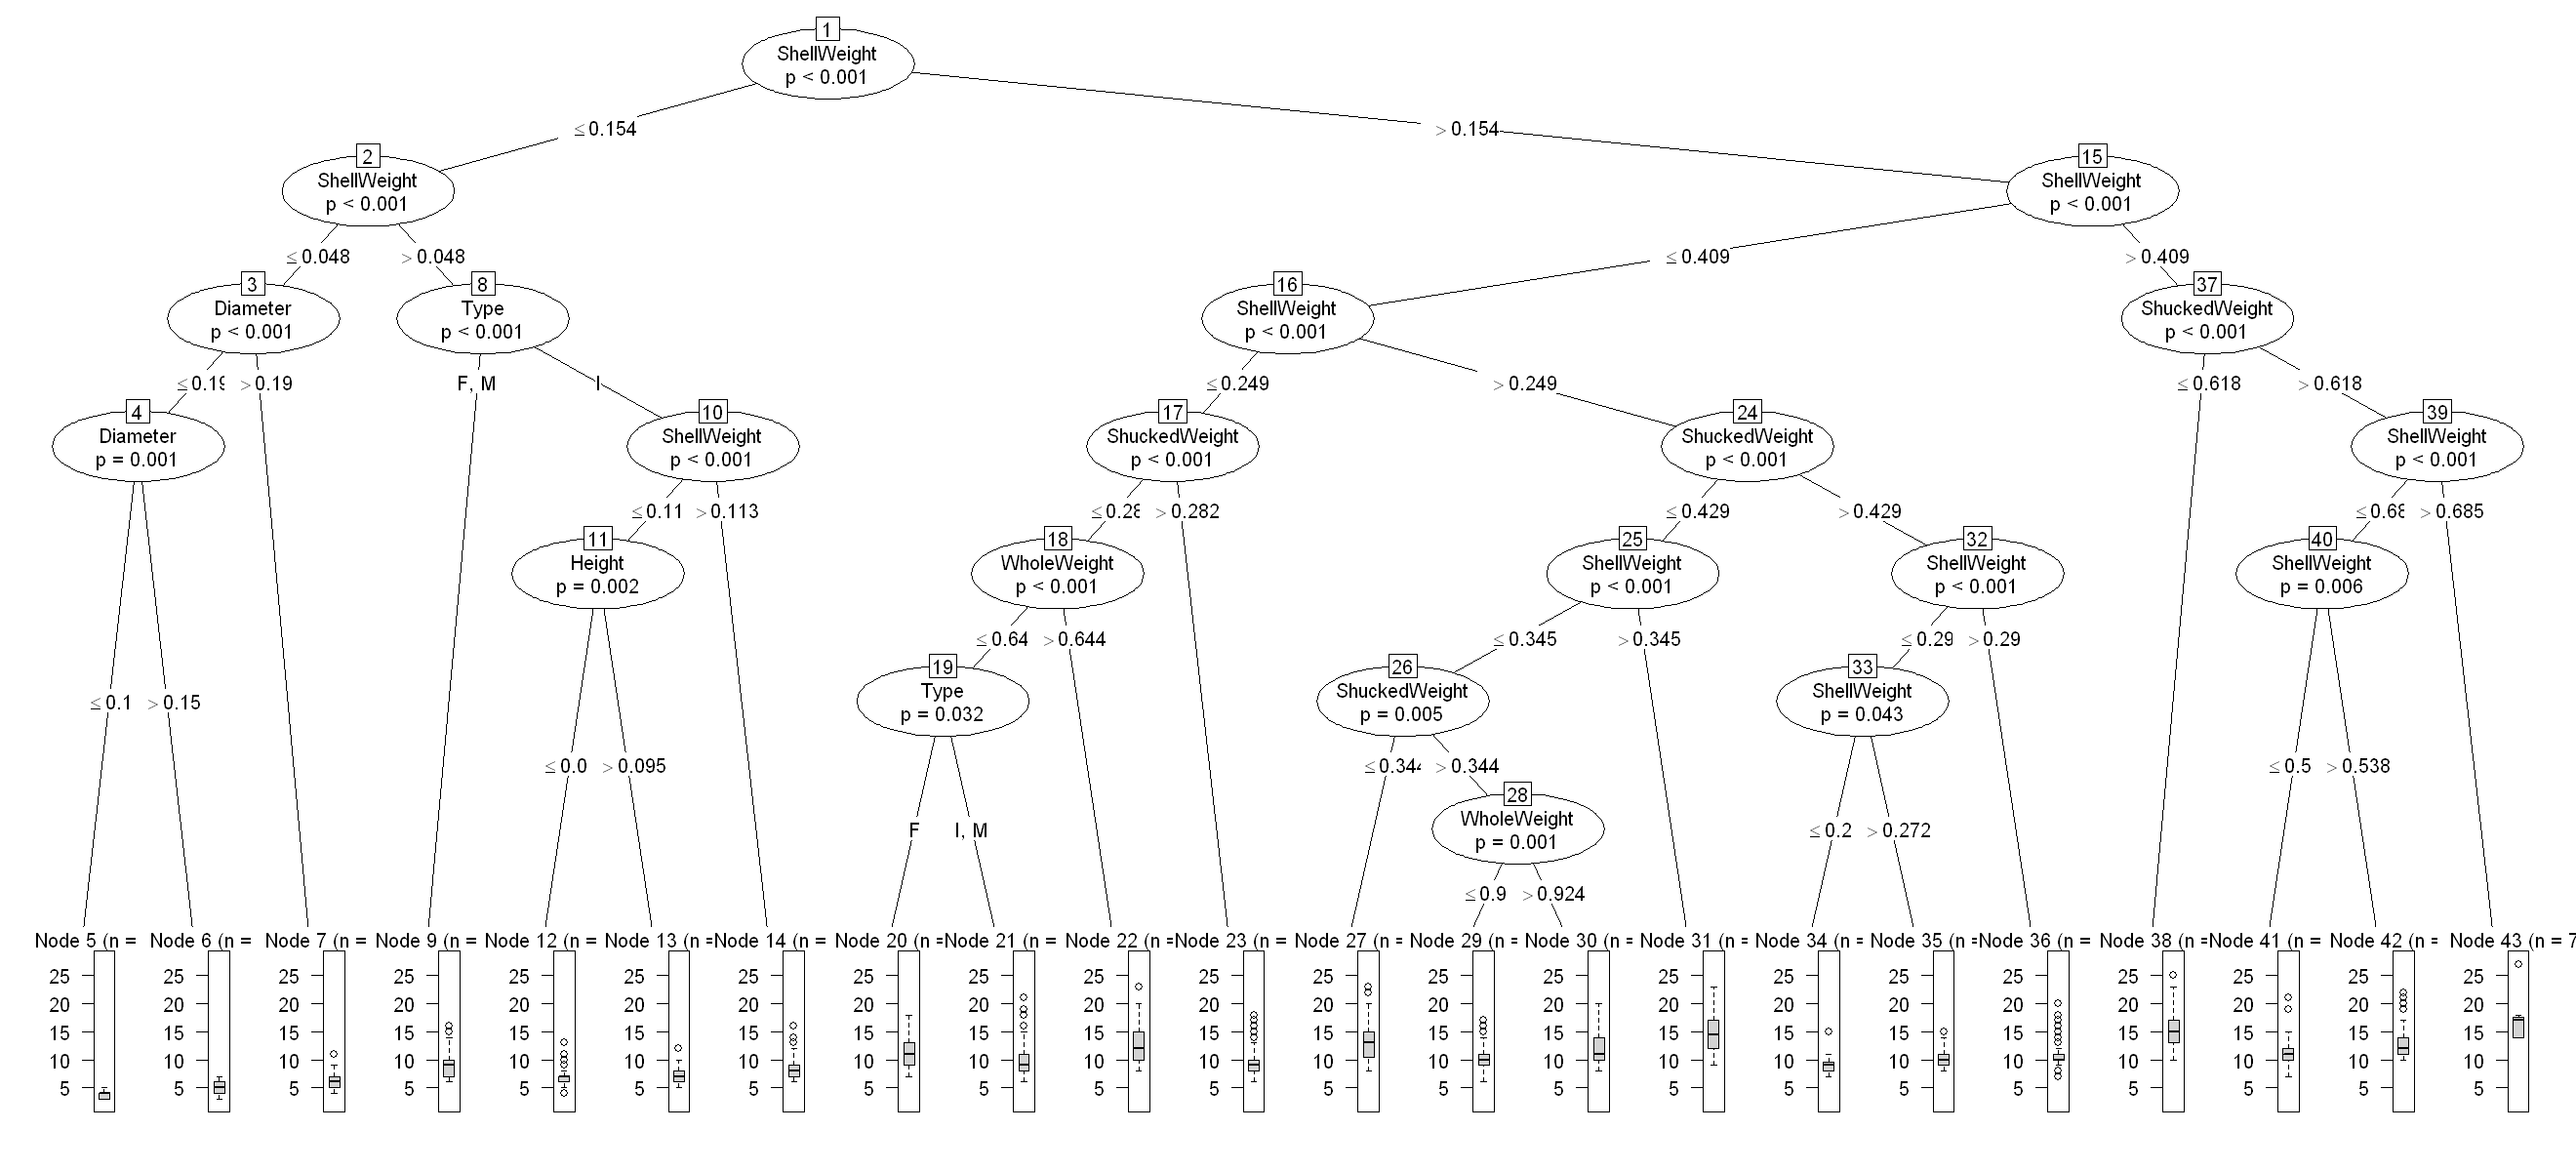

In [4]:
rtab <- ctree(Rings ~ .,data = tr_ab) 
plot(rtab)

In [5]:
(RMSE(tr_ab$Rings, predict(rtab, tr_ab)))  #训练集的RMSE
(RMSE(te_ab$Rings, predict(rtab, te_ab)))    #测试集的RMSE

[1] 2.149433

[1] 2.314431

性能优于rpart决策树,参见 https://github.com/A-Pai/Tree-Based-Learning-Methods-in-R/blob/main/decision%20tree/1-rpart.ipynb

### 自变量取连续值


数据集 $friedman1$按此方式生成模拟数据：自变量 $\{X_j\}^{10}_ {j=1}\overset{iid}{\sim} U(0,1)$，$Y=10\sin(\pi X_1X_2)+20(X_3-0.5)^2+10X_4+5X_5+\epsilon$ ,  其中$\epsilon\sim N(0,\sigma)$ ，请注意仅仅$X_1 \sim X_{5} $ 与 $Y$ 相关 。

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(partykit,treemisc)
p_load(rattle) # 使用其中的fancyRpartPlot函数
p_load(skimr)
s <- skim_tee

In [2]:
set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(1000, nx = 7, sigma = 0.1)
s(fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          8     
_______________________          
Column type frequency:           
  numeric                  8     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean    sd        p0    p25    p50    p75   p100 hist 
1 y                     0             1 14.1   4.88  1.65      10.7   14.1   17.5   27.5   ▂▅▇▅▁
2 x1                    0             1  0.505 0.294 0.00129    0.238  0.511  0.769  1.00  ▇▇▇▇▇
3 x2                    0             1  0.492 0.292 0.00134    0.231  0.499  0.749  0.999 ▇▇▇▇▇
4 x3                    0             1  0.490 0.285 0.000113   0.242  0.482  0.740  0.999 ▇▇▇▇▇
5 x4                    0 

In [3]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(fr), nrow(fr) * 0.5)
tr_fr <- fr[I, ]
te_fr <- fr[-I, ]
s(tr_fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             500   
Number of columns          8     
_______________________          
Column type frequency:           
  numeric                  8     
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   mean    sd        p0    p25    p50    p75   p100 hist 
1 y                     0             1 14.0   5.09  1.97      10.7   14.0   17.5   27.2   ▂▅▇▆▁
2 x1                    0             1  0.506 0.290 0.00166    0.251  0.507  0.768  0.996 ▇▇▇▇▇
3 x2                    0             1  0.481 0.296 0.00473    0.206  0.477  0.747  0.994 ▇▆▆▆▆
4 x3                    0             1  0.498 0.274 0.000852   0.272  0.489  0.728  0.999 ▆▇▇▇▆
5 x4                    0 

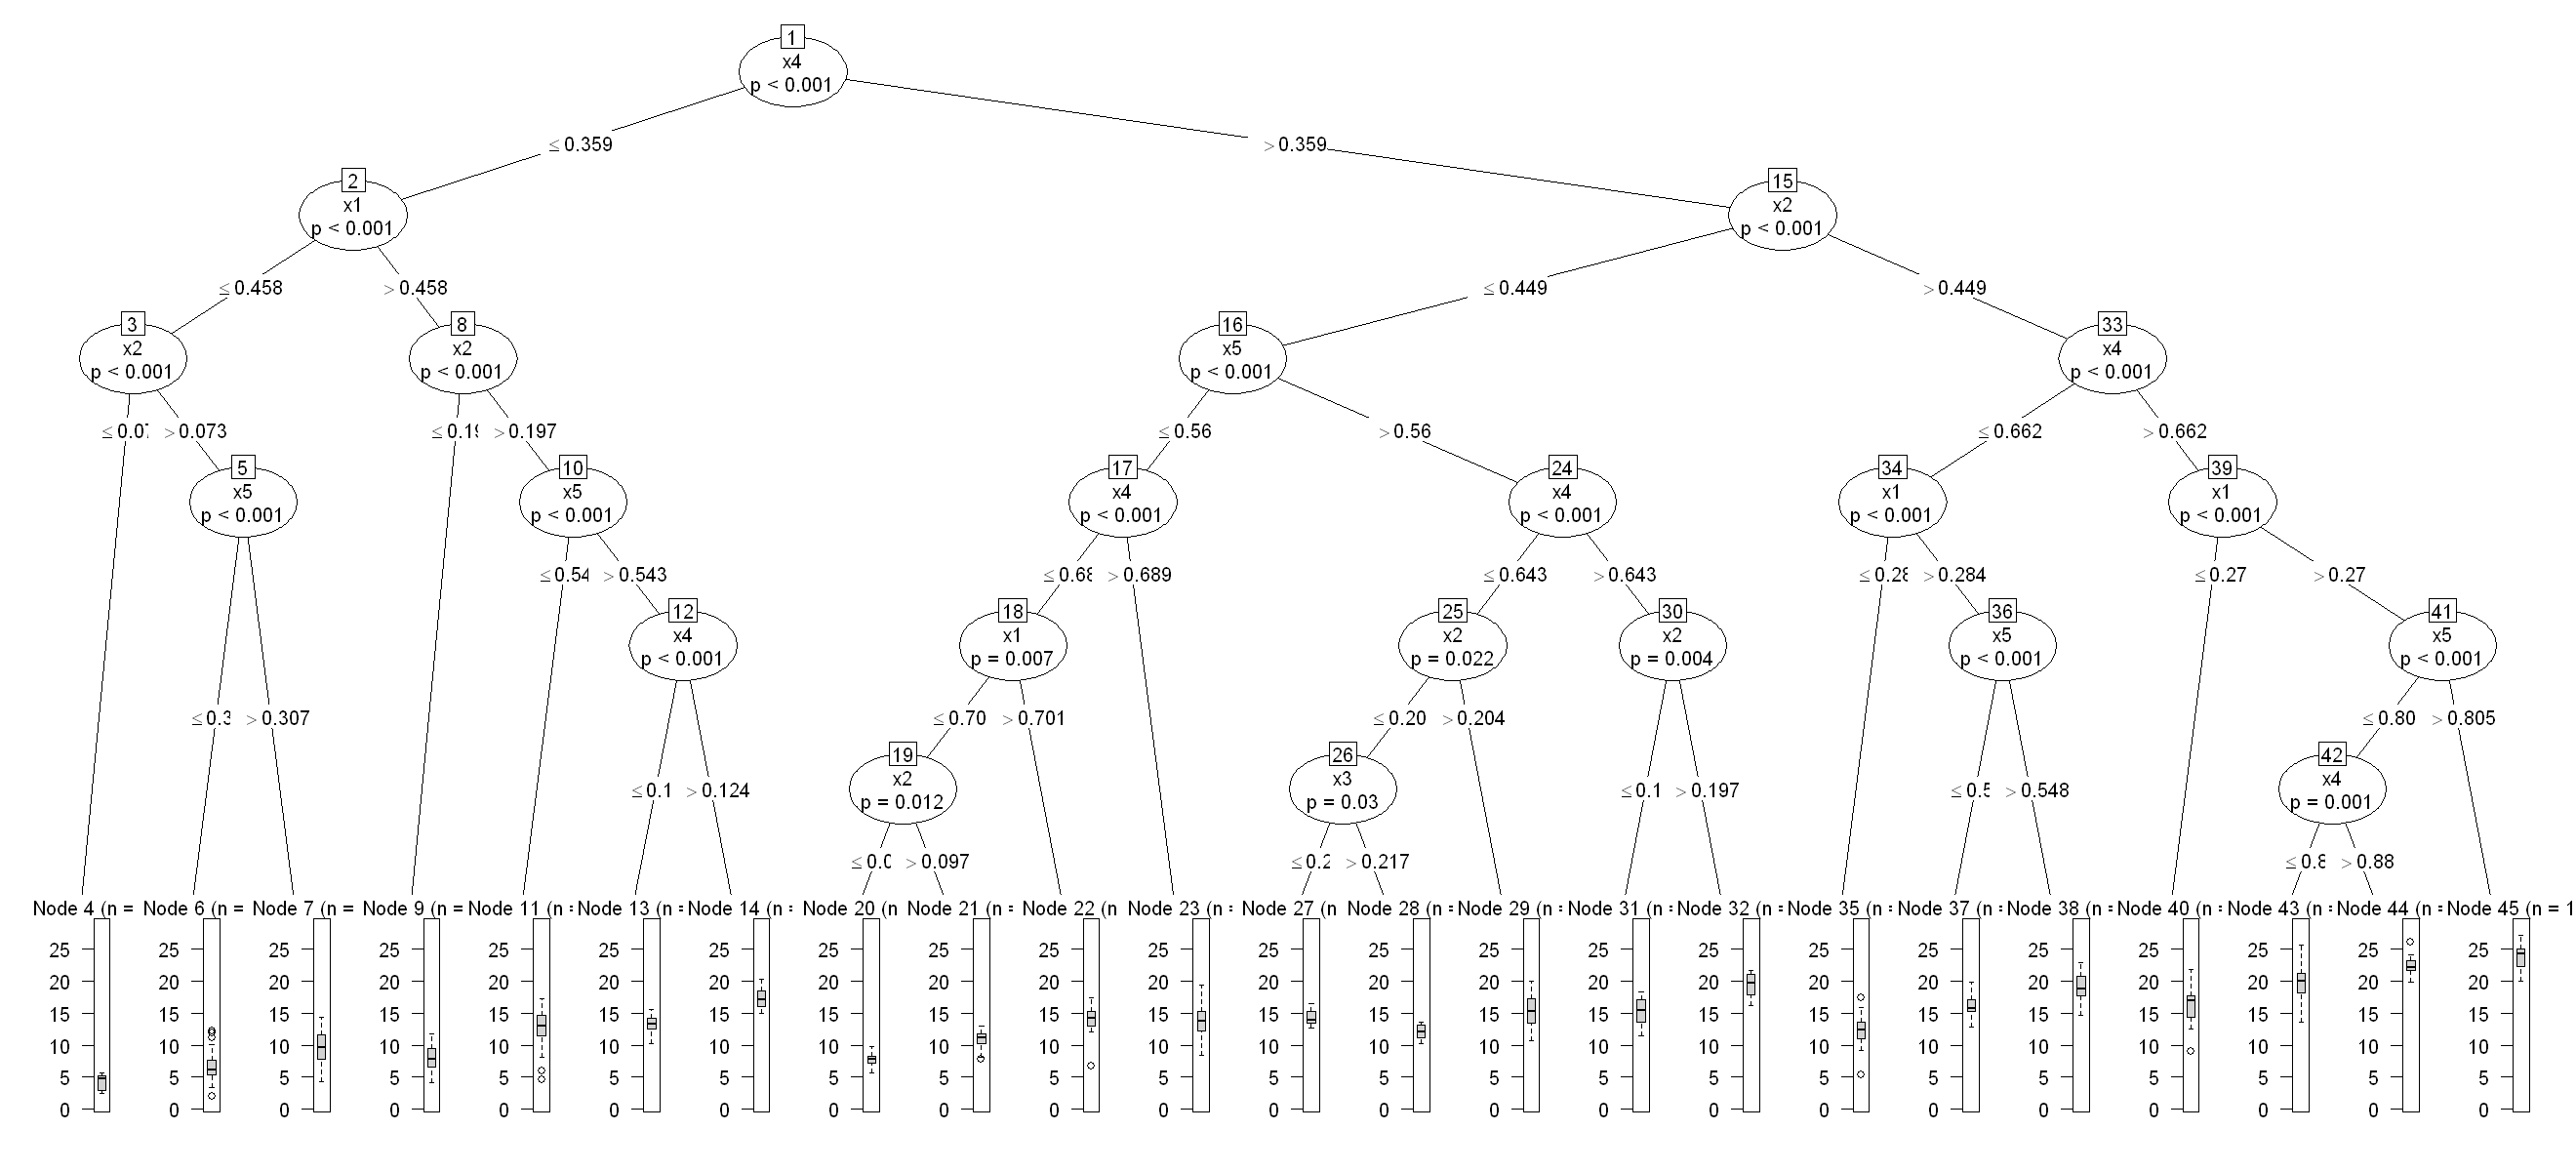

In [4]:
rt_CIT <- ctree(y ~ ., data = tr_fr)  
plot(rt_CIT)

In [5]:
class(rt_CIT)

[1] "constparty" "party"

In [8]:
(measures::RMSE(tr_fr$y, predict(rt_CIT, tr_fr)))  #训练集的RMSE
(measures::RMSE(te_fr$y, predict(rt_CIT, te_fr)))    #测试集的RMSE

[1] 2.19866

[1] 2.909433

性能与rpart可比，参见 https://github.com/A-Pai/Tree-Based-Learning-Methods-in-R/blob/main/decision%20tree/1-rpart.ipynb

**采用Permutation法评价变量重要性：**

--原理参考 https://blog.csdn.net/wxl173/article/details/129814777

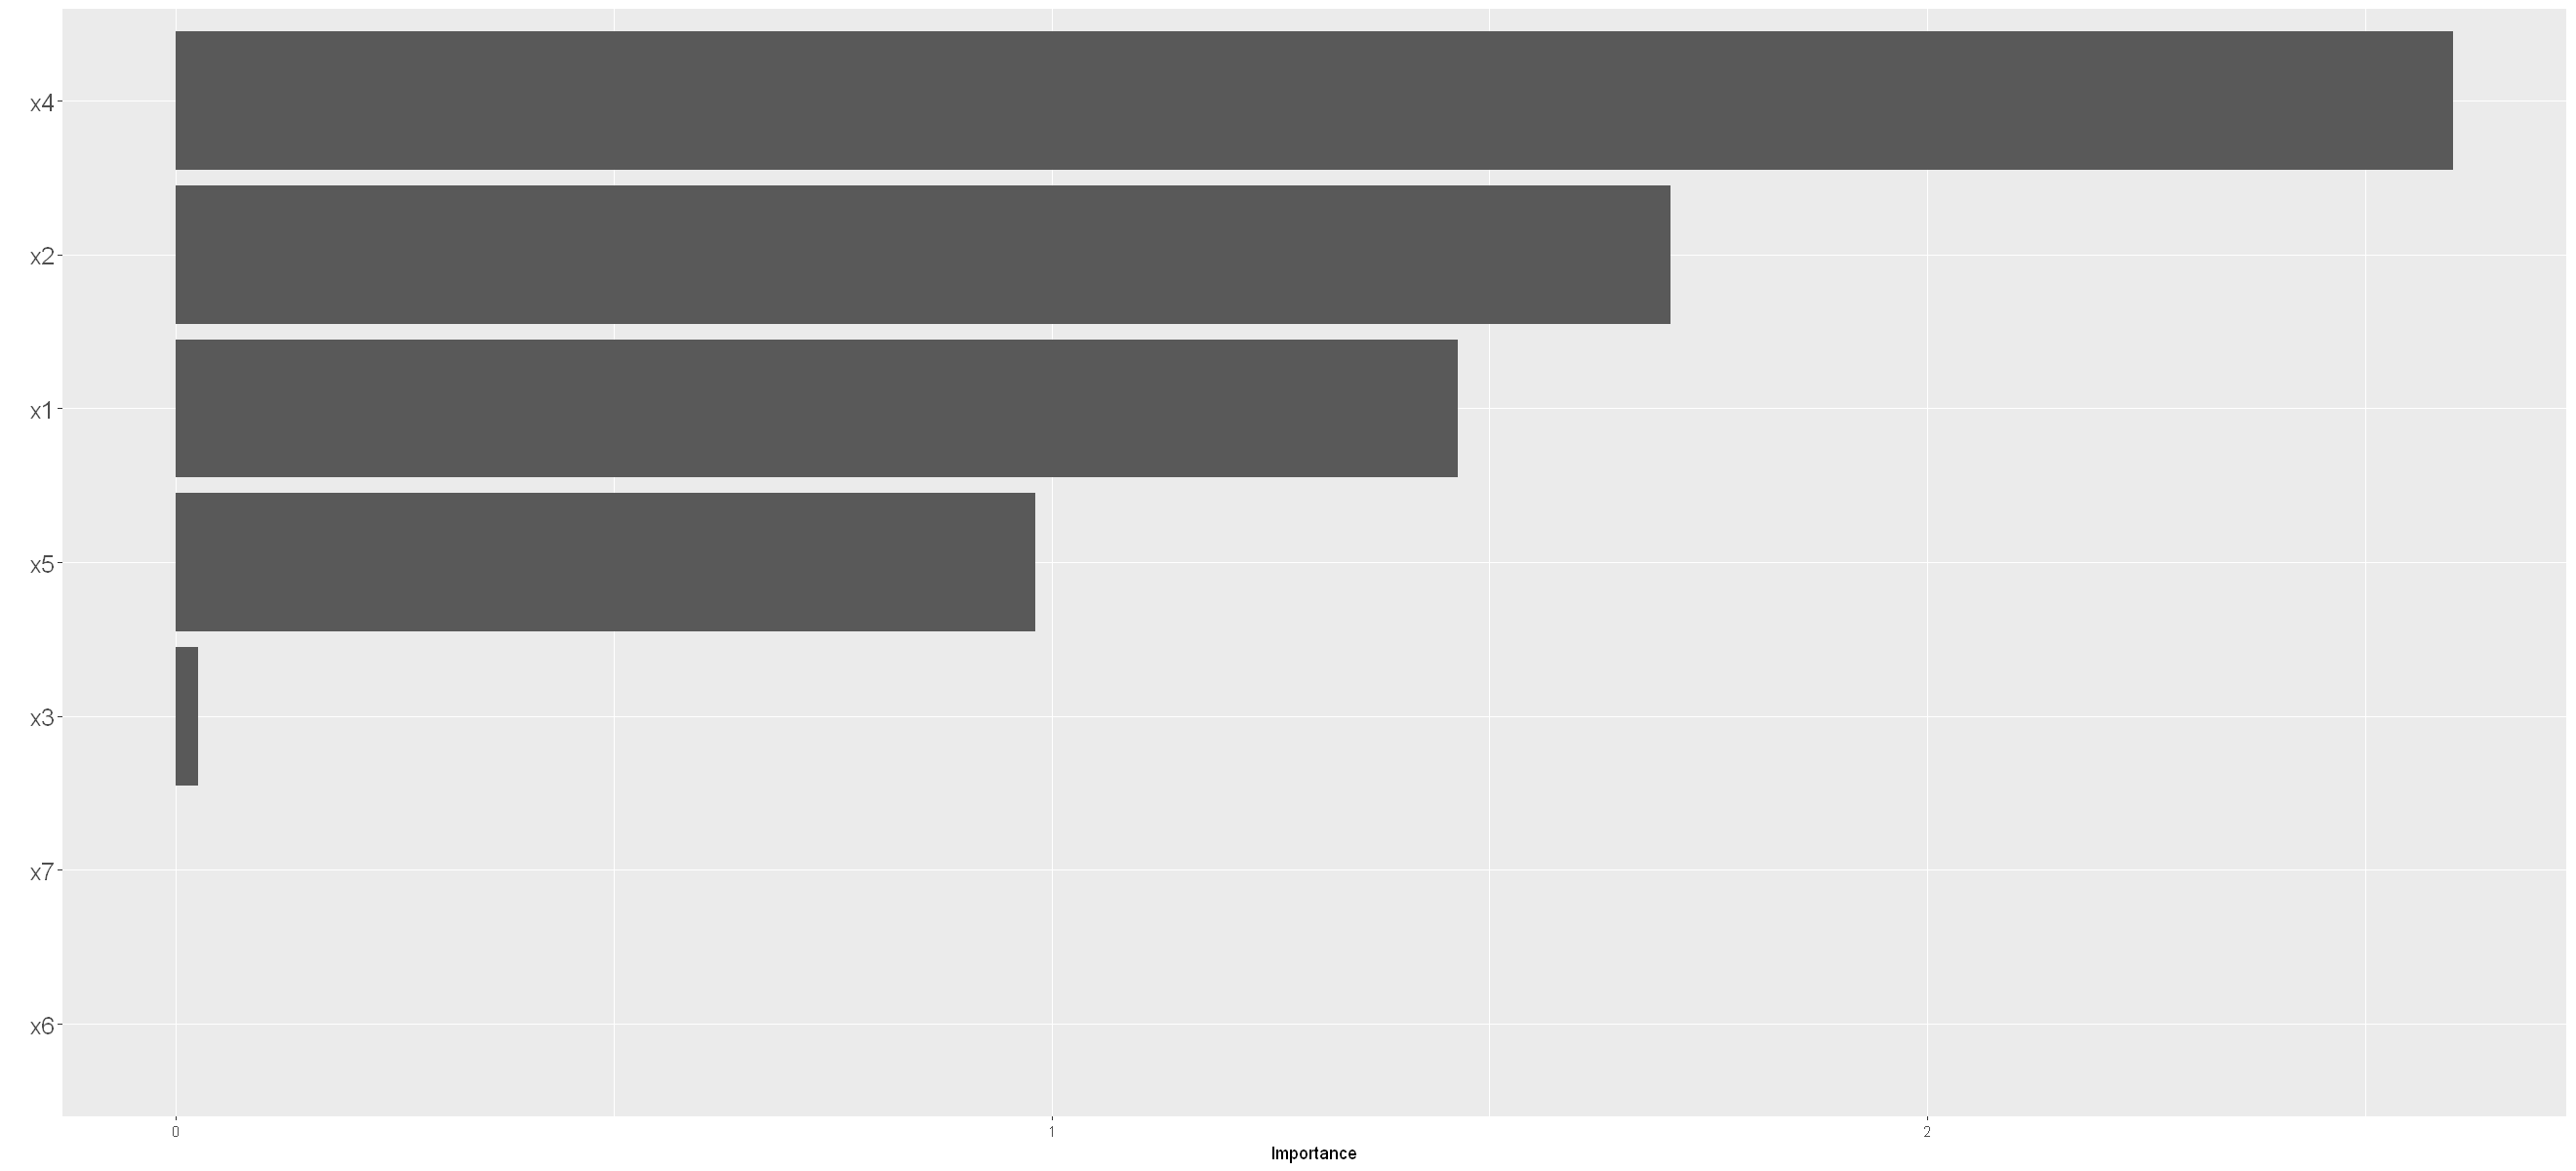

In [16]:
p_load(vip)
p_load(ggplot2)  # for easily arranging multiple ggplot2 plots

pfun <- function(object, newdata) predict(object, newdata = newdata)
vip(rt_CIT, method = "permute", train = tr_fr, target = "y", metric = "rmse", pred_wrapper = pfun)+
    theme(axis.text.y=element_text(size=15))

可见：通过Permutation法，CIT正确地评价了x6、x7的重要性--与因变量无关

##  值缺失

#### 建模时属性值缺失

In [20]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(partykit,coin)
p_load(skimr)
s <- skim_tee


In [22]:
p_load(AppliedPredictiveModeling)
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 2096, H: 2081         

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

In [23]:
# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
tr_ab <- ab[I, ]
te_ab <- ab[-I, ]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1044, H: 1044      

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

将第一个样例的ShellWeight值置为缺失

In [24]:
tr_ab[1,"ShellWeight"] <- NA
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1044, H: 1044      

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

In [28]:
ct_abm <- ctree(Rings ~ ., data = tr_ab) 
print(ct_abm)
#CIT建模时处理缺失值的方式是利用剩下的完整样例


Model formula:
Rings ~ Type + LongestShell + Diameter + Height + WholeWeight + 
    ShuckedWeight + VisceraWeight + ShellWeight

Fitted party:
[1] root
|   [2] ShellWeight <= 0.254
|   |   [3] ShellWeight <= 0.152
|   |   |   [4] Type in F, M
|   |   |   |   [5] ShellWeight <= 0.05: L (n = 33, err = 6.1%)
|   |   |   |   [6] ShellWeight > 0.05: L (n = 156, err = 35.3%)
|   |   |   [7] Type in I
|   |   |   |   [8] Height <= 0.095: L (n = 252, err = 1.6%)
|   |   |   |   [9] Height > 0.095: L (n = 195, err = 10.8%)
|   |   [10] ShellWeight > 0.152
|   |   |   [11] ShuckedWeight <= 0.2865
|   |   |   |   [12] Type in F, M
|   |   |   |   |   [13] ShellWeight <= 0.19: H (n = 81, err = 42.0%)
|   |   |   |   |   [14] ShellWeight > 0.19: H (n = 57, err = 14.0%)
|   |   |   |   [15] Type in I: L (n = 81, err = 38.3%)
|   |   |   [16] ShuckedWeight > 0.2865
|   |   |   |   [17] Type in F
|   |   |   |   |   [18] ShuckedWeight <= 0.385: H (n = 50, err = 32.0%)
|   |   |   |   |   [19] Shucked

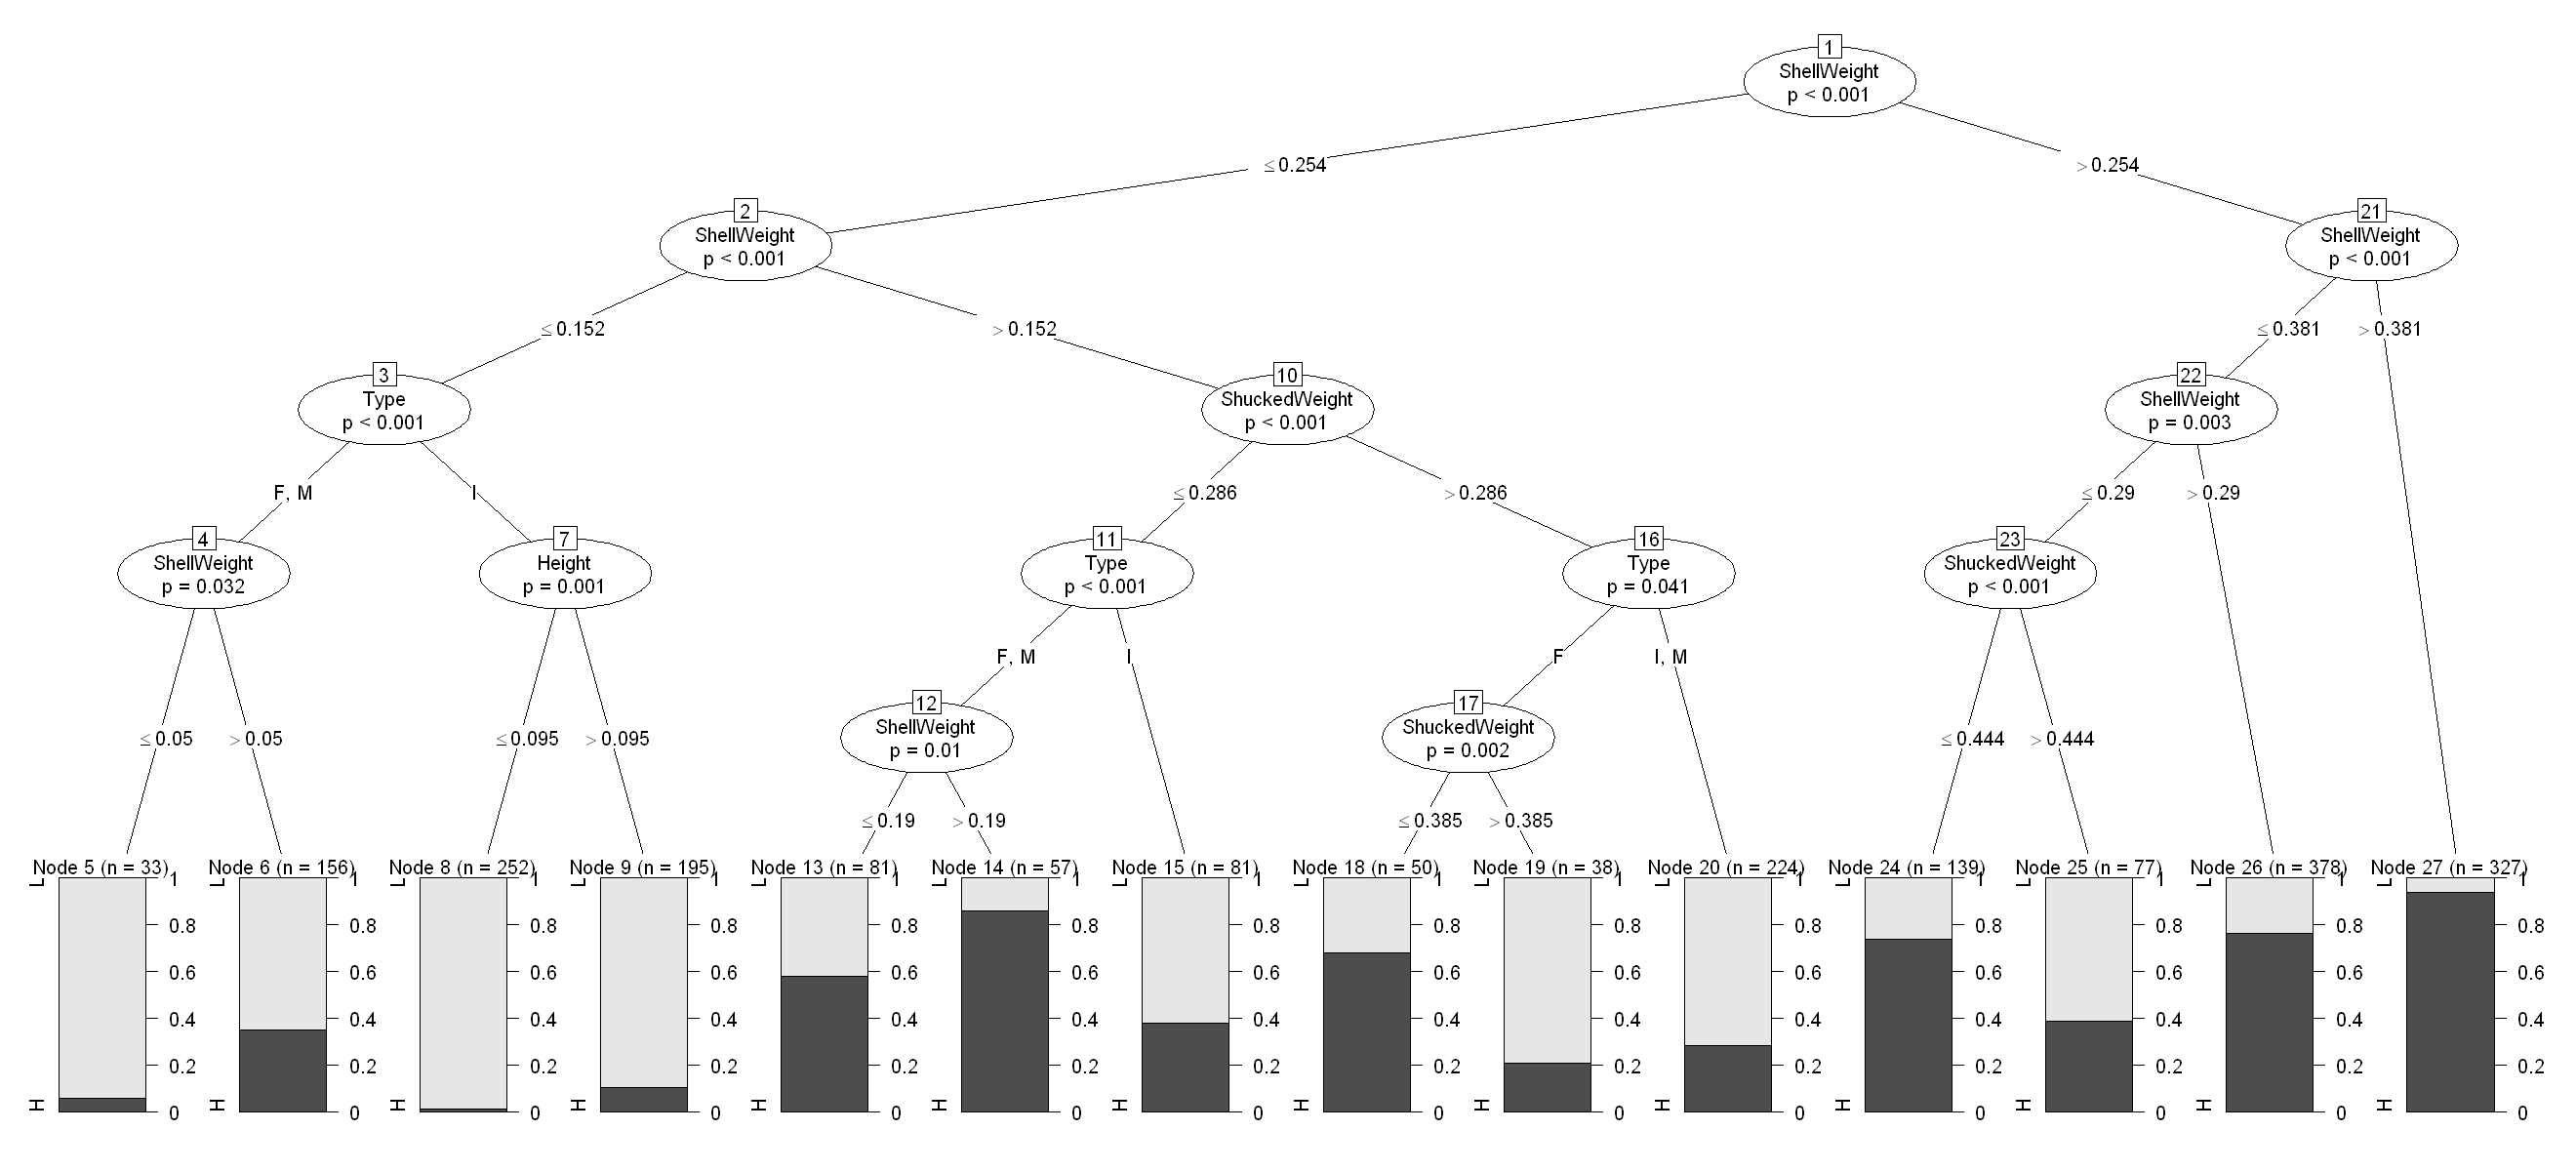

In [29]:
plot(ct_abm) 

In [30]:
mean(predict(ct_abm) != tr_ab$Rings)
mean(predict(ct_abm, te_ab ) != te_ab$Rings)


[1] 0.2001916

[1] 0.2178076

与完整的训练集得到的模型性能相同，可见少量值缺失对模型的性能影响不大

#### 预测时自变量值缺失

In [1]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(party,AppliedPredictiveModeling)
p_load(skimr)
s <- skim_tee

In [2]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 9, labels = c("L", "H")) # 处理成二类，逻辑型factor的levels的排序默认是：FALSE,TRUE，分别对应于"L","H"

# 将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(ab), nrow(ab) * 0.5)
tr_ab <- ab[I, ]
te_ab <- ab[-I, ]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1044, H: 1044      

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

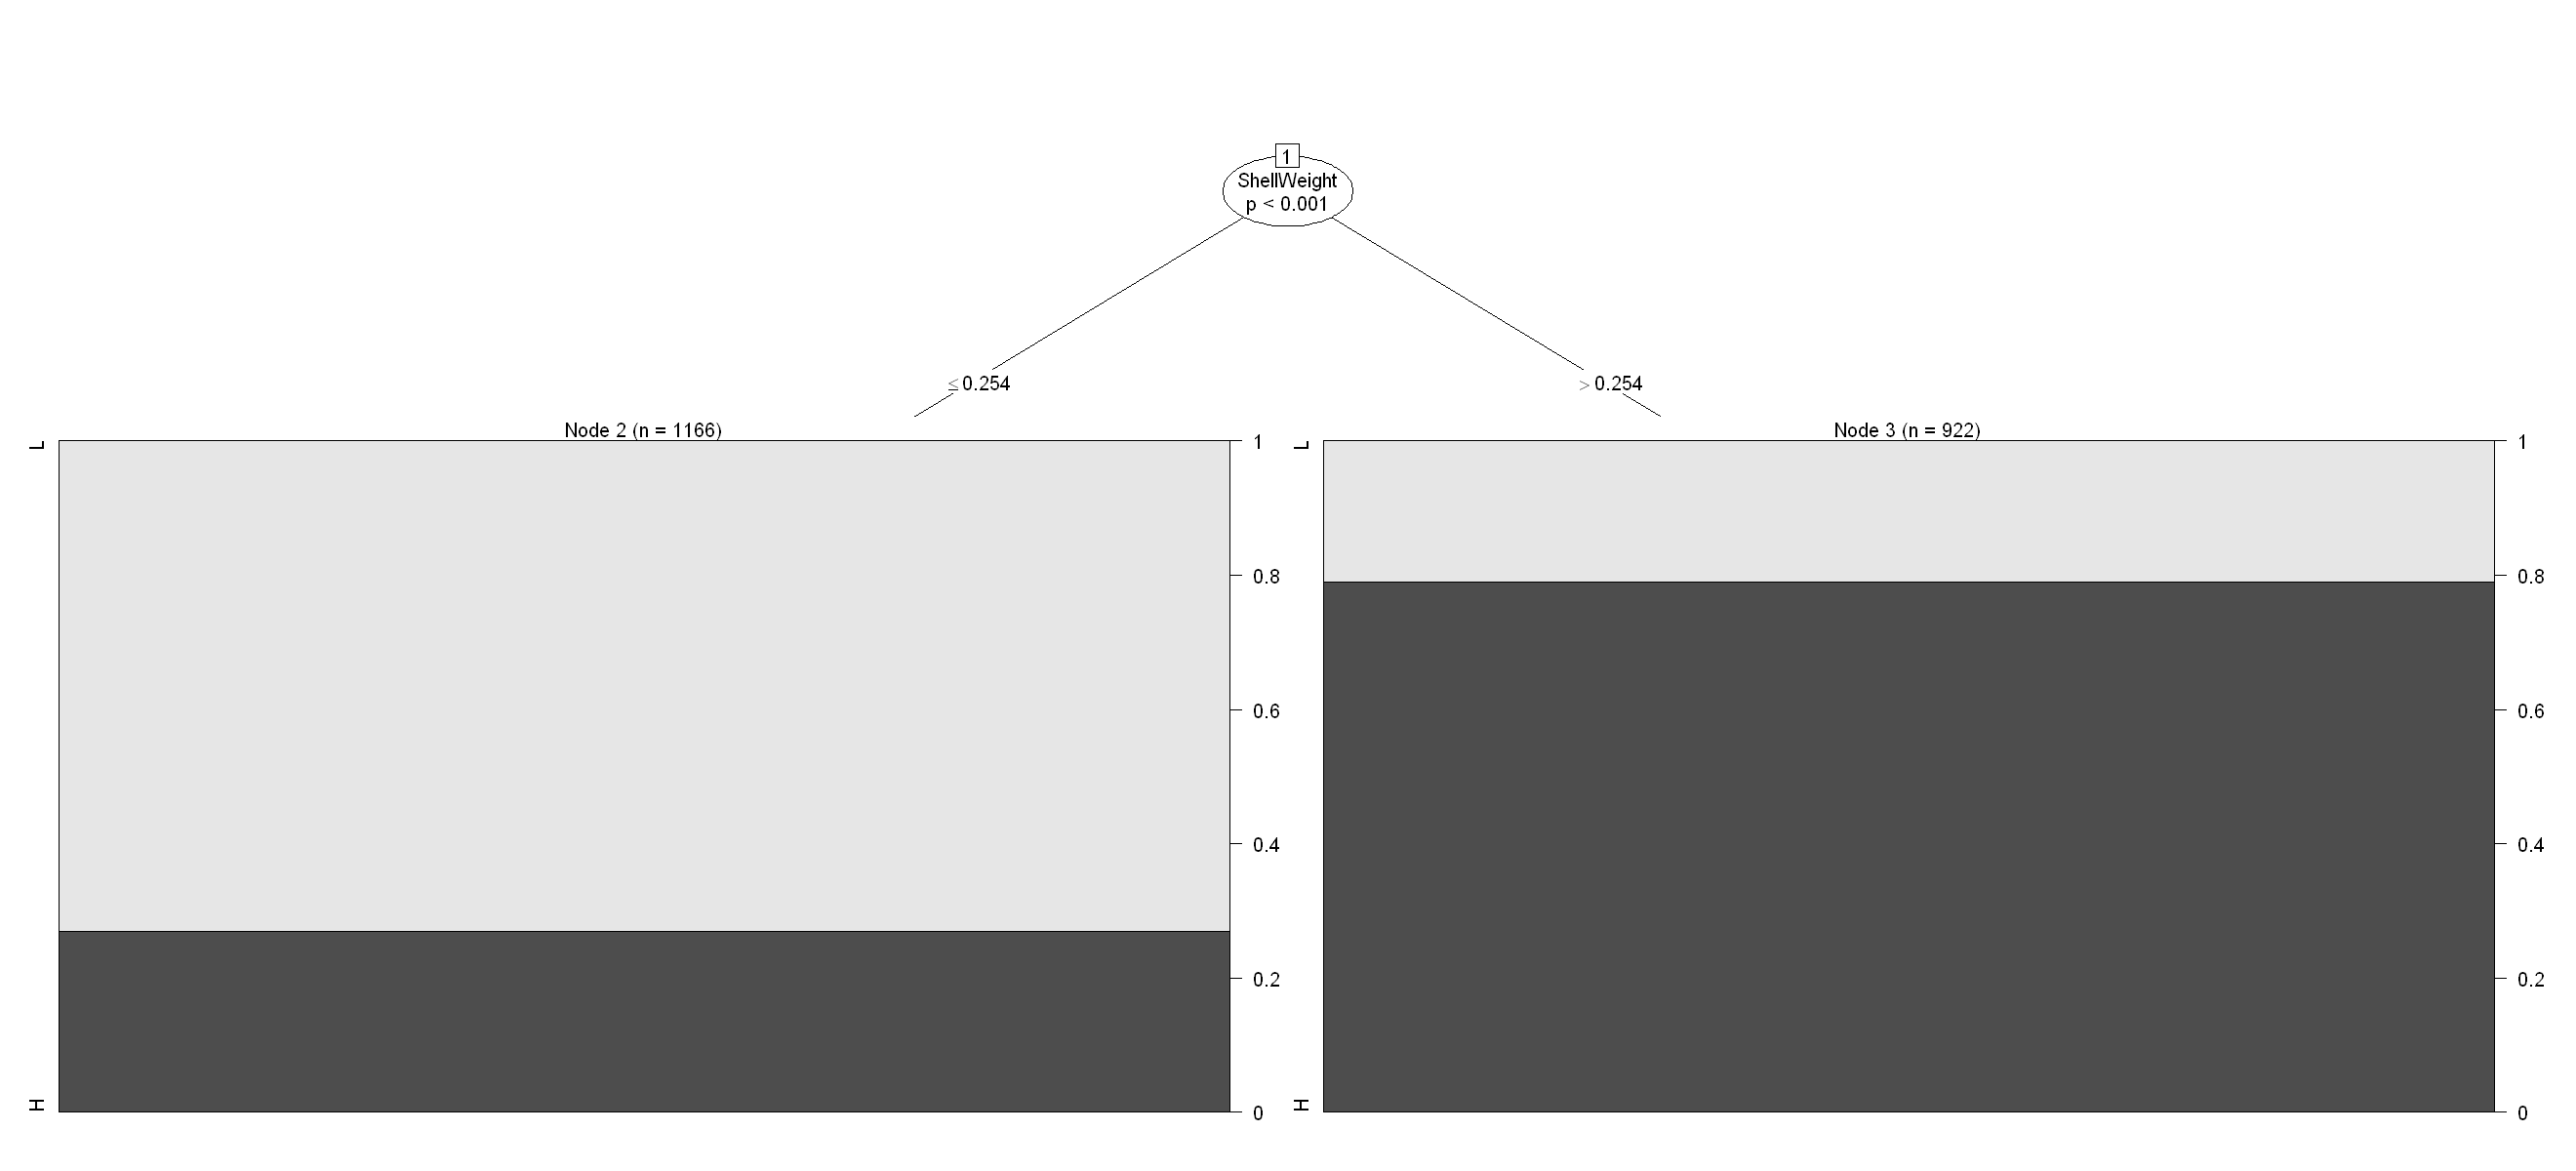

In [4]:
ct_ab <- ctree(Rings ~ .,data = tr_ab, 
      controls = ctree_control(maxsurrogate = 6, maxdepth = 1))  #maxsurrogate当前只适用于有序变量，本问题只有6个有序自变量
plot(ct_ab)

主分支为：

In [6]:
ct_ab@tree$psplit

ShellWeight <= 0.254

替代分枝为：

In [7]:
ct_ab@tree$ssplits

[[1]]
[[1]][[1]]
[1] 5

[[1]][[2]]
[1] TRUE

[[1]][[3]]
[1] 0.8995

[[1]][[4]]
NULL

[[1]][[5]]
[1] 1

[[1]][[6]]
NULL


[[2]]
[[2]][[1]]
[1] 3

[[2]][[2]]
[1] TRUE

[[2]][[3]]
[1] 0.445

[[2]][[4]]
NULL

[[2]][[5]]
[1] 1

[[2]][[6]]
NULL


[[3]]
[[3]][[1]]
[1] 7

[[3]][[2]]
[1] TRUE

[[3]][[3]]
[1] 0.182

[[3]][[4]]
NULL

[[3]][[5]]
[1] 1

[[3]][[6]]
NULL


[[4]]
[[4]][[1]]
[1] 2

[[4]][[2]]
[1] TRUE

[[4]][[3]]
[1] 0.56

[[4]][[4]]
NULL

[[4]][[5]]
[1] 1

[[4]][[6]]
NULL


[[5]]
[[5]][[1]]
[1] 6

[[5]][[2]]
[1] TRUE

[[5]][[3]]
[1] 0.355

[[5]][[4]]
NULL

[[5]][[5]]
[1] 1

[[5]][[6]]
NULL


[[6]]
[[6]][[1]]
[1] 4

[[6]][[2]]
[1] TRUE

[[6]][[3]]
[1] 0.145

[[6]][[4]]
NULL

[[6]][[5]]
[1] 1

[[6]][[6]]
NULL

"ShellWeight <= 0.254"向左分枝的替代分枝的规则依次为：

1. WholeWeight<0.8995,向左分枝，判断为L，否则向右分枝，判断为H
2. Diameter<0.4450,向左分枝，判断为L，否则向右分枝，判断为H
3. VisceraWeight<0.1820,向左分枝，判断为L，否则向右分枝，判断为H  
3. LongestShell<0.5600,向左分枝，判断为L，否则向右分枝，判断为H
3. ShuckedWeight<0.3550,向左分枝，判断为L，否则向右分枝，判断为H
4. Height<0.1450,向左分枝，判断为L，否则向右分枝，判断为H
   
计算过程如下：

In [7]:
xnames <- sapply(tr_ab[, -c(8, 9)], class)
xnames_n <- names(xnames[xnames == "numeric"])

rc <- as.data.frame(matrix(nrow = 0, ncol = 3)) # 创建一个3列的空对象
names(rc) <- c("x", "sp", "st") # 分别积累变量名、分枝点、统计量

r <- 0
for (name in xnames_n) {
  p <- sort(unique(tr_ab[[name]]))
  p <- p[-c(1, length(p))]
  res <- sapply(p, FUN = function(x) {
    chisq.test(table(tr_ab$ShellWeight <= 0.254, tr_ab[[name]] <= x))$statistic# 用的是卡方统计量，为何不用acc？
  })

  r <- r + 1
  rc[r, 1] <- name
  rc[r, 2] <- p[which.max(res)]
  rc[r, 3] <- max(res)
}
(rc[order(rc$st, decreasing = T), ])

,x,sp,st
,<chr>,<dbl>,<dbl>
4,WholeWeight,0.8995,1488.895
2,Diameter,0.4450,1354.698
6,VisceraWeight,0.1820,1260.392
1,LongestShell,0.5600,1257.440
5,ShuckedWeight,0.3550,1155.915
3,Height,0.1450,1143.605


依据上表中统计量“st”的降序选择替代分枝

直观地观察surrogate分枝与主分枝的一致性：

In [8]:
p_load(measures)
(with(tr_ab, ACC(ShellWeight <= 0.254, WholeWeight <= 0.8995))) 
(with(tr_ab, ACC(ShellWeight <= 0.254, Diameter <= 0.4450))) 
(with(tr_ab, ACC(ShellWeight <= 0.254, VisceraWeight <= 0.1820))) 
(with(tr_ab, ACC(ShellWeight <= 0.254, LongestShell <= 0.5600))) 
(with(tr_ab, ACC(ShellWeight <= 0.254, ShuckedWeight <= 0.3550))) 
(with(tr_ab, ACC(ShellWeight <= 0.254, Height <= 0.1450))) 

[1] 0.9238506

[1] 0.9046935

[1] 0.8893678

[1] 0.8898467

[1] 0.8721264

[1] 0.8716475

**验证“Surrogate splits”的用法**

首先，“ShellWeight”值缺失：

In [9]:
te_ab[1,"ShellWeight"] <- NA
te_ab[1,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,F,0.53,0.42,0.135,0.677,0.2565,0.1415,NA,L


替代分枝为：WholeWeight<0.8995

In [10]:
predict(ct_ab, te_ab[1,])

[1] L
Levels: L H

In [ ]:
te_ab[16,"ShellWeight"] <- NA
te_ab[16,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
27,F,0.58,0.45,0.185,0.9955,0.3945,0.272,NA,H


替代分枝为：WholeWeight≥0.8995

In [ ]:
predict(ct_ab, te_ab[16,])

[1] H
Levels: L H

ShellWeight和WholeWeight均缺失

In [11]:
te_ab[1,"WholeWeight"] <- NA
te_ab[1,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,F,0.53,0.42,0.135,NA,0.2565,0.1415,NA,L


替代分枝为：Diameter<0.445

In [12]:
predict(ct_ab, te_ab[1,]) 

[1] L
Levels: L H

In [13]:
te_ab[16,"WholeWeight"] <- NA
te_ab[16,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
27,F,0.58,0.45,0.185,NA,0.3945,0.272,0.285,H


替代分枝为：Diameter≥0.445

In [ ]:
predict(ct_ab, te_ab[16,]) 

[1] H
Levels: L H

ShellWeight和WholeWeight、Diameter均缺失

In [14]:
te_ab[1,"Diameter"] <- NA
te_ab[1,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,F,0.53,NA,0.135,NA,0.2565,0.1415,NA,L


替代分枝为：VisceraWeight<0.1820

In [ ]:
predict(ct_ab, te_ab[1,]) 

3 
H 
Levels: L H

In [ ]:
te_ab[16,"Diameter"] <- NA
te_ab[16,]

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
27,F,0.58,NA,0.185,NA,0.3945,0.272,NA,H


替代分枝为：VisceraWeight≥0.1820

In [ ]:
predict(ct_ab, te_ab[16,]) 

[1] H
Levels: L H

...

上一个替代分枝值缺失，则用下一个，所有替代自变量缺失，取大类


## 时间复杂度


#### classification-自变量全为连续值


In [18]:
options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(rpart)
p_load(party)
p_load(skimr)
s <- skim_tee

In [19]:
set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(1000, nx = 20, sigma = 0.1)
fr$y <- factor(ifelse(fr$y < 14.2, 0, 1))
s(fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          21    
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  20    
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts    
1 y                     0             1 FALSE          2 0: 506, 1: 494

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   skim_variable n_missing complete_rate  mean    sd        p0   p25   p50   p75  p100 hist 
 1 x1                    0             1 0.505 0.294 0.00129   0.238 0.511 0.769 1.00  ▇▇▇▇▇
 2 x2

  |==================================================================================================================================| 100%

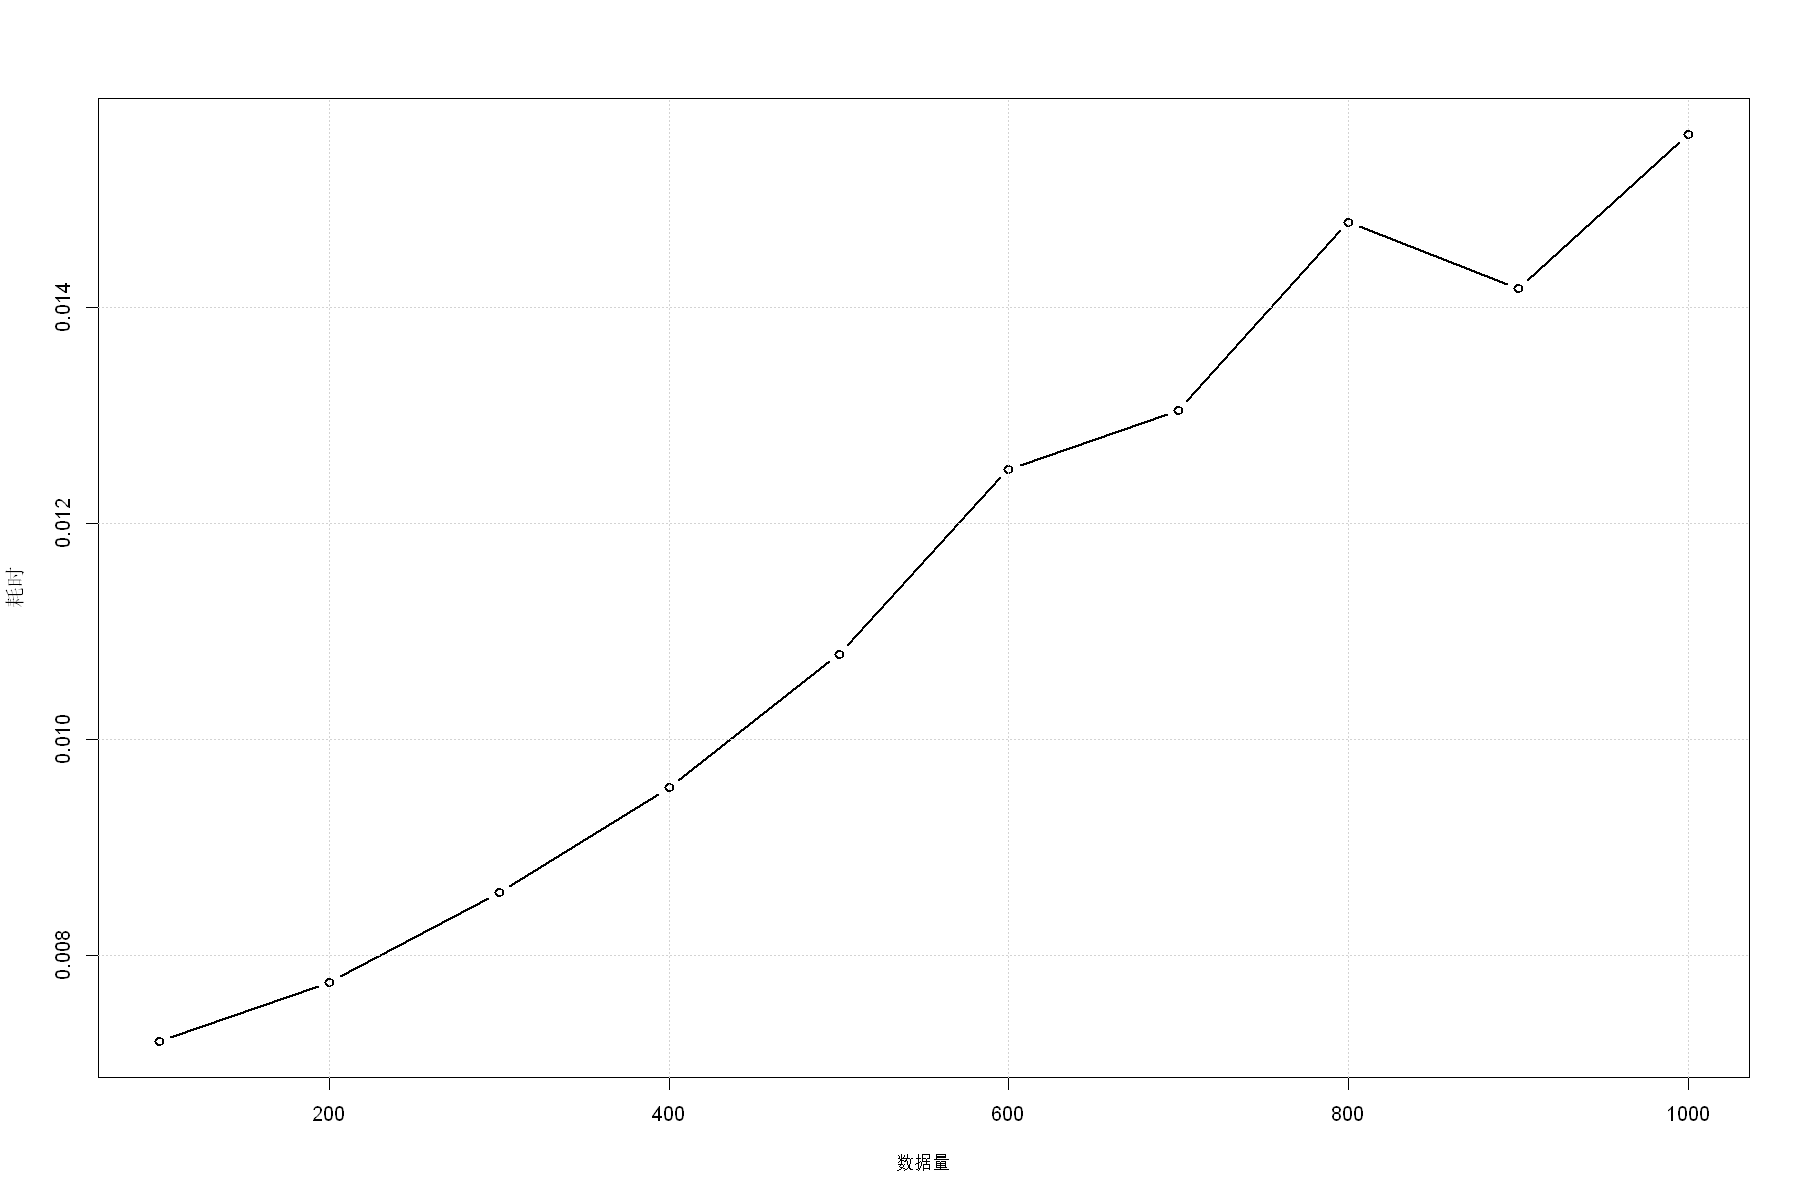

In [27]:
N <- 10 # 数据规格数
M <- 100 # 每种数据量实验次数
rc <- matrix(-1, M, N) # 用于存储实验结果
nr <- nrow(fr)
colnames(rc) <- as.character(1:N) # 每列对应于不同的数据规格


pb <- txtProgressBar(style = 3)
for (n in 1:N) {
  for (m in 1:M) {
    set.seed(n * 1000 + m)
    I <- sample(nr, (n * nr / N))
    d <- fr[I, ]
    timestart <- Sys.time()
    ctree(y ~ ., data = d)
    rc[m, n] <- difftime(Sys.time(), timestart, units = "secs")
  }
  setTxtProgressBar(pb, n / N)
}

plot(((1:n)*nr/N), colMeans(rc), type = "b", lwd = 2, xlab = "数据量",ylab = "耗时")
grid()

# 可见基本呈直线，时间复杂度较低

#### regression-属性全为连续值


In [28]:
options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅
p_load(rpart)
p_load(skimr)
s <- skim_tee

In [29]:
set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(1000, nx = 20, sigma = 0.1)
s(fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          21    
_______________________          
Column type frequency:           
  numeric                  21    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   skim_variable n_missing complete_rate   mean    sd        p0    p25    p50    p75   p100 hist 
 1 y                     0             1 14.1   4.88  1.72      10.8   14.2   17.5   27.3   ▂▅▇▅▁
 2 x1                    0             1  0.505 0.294 0.00129    0.238  0.511  0.769  1.00  ▇▇▇▇▇
 3 x2                    0             1  0.492 0.292 0.00134    0.231  0.499  0.749  0.999 ▇▇▇▇▇
 4 x3                    0             1  0.490 0.285 0.000113   0.242  0.482  0.740  0.999 ▇▇▇▇▇
 5 x4                

  |==================================================================================================================================| 100%

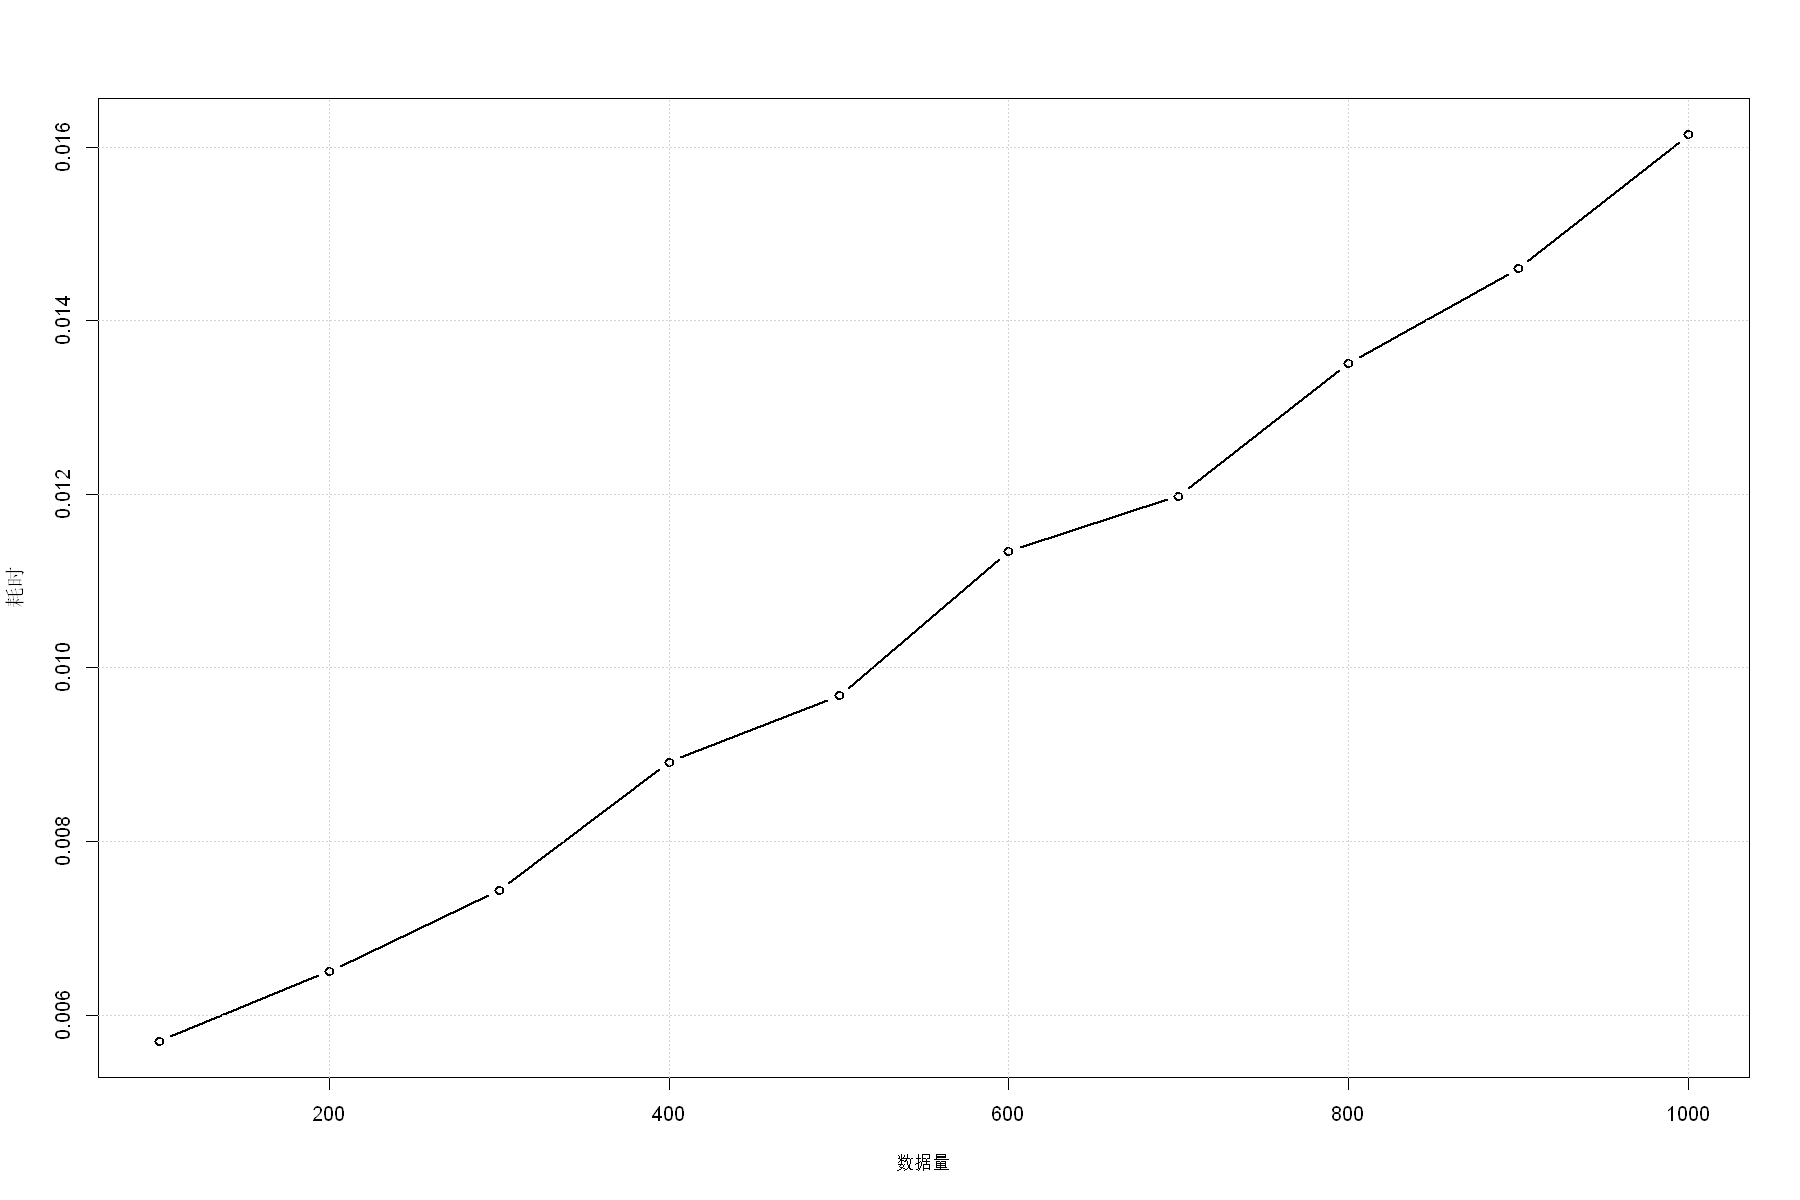

In [30]:
N <- 10 # 数据规格数
M <- 100 # 每种数据量实验次数
rc <- matrix(-1, M, N) # 用于存储实验结果
colnames(rc) <- as.character(1:N) # 每列对应于不同的数据规格
nr <- nrow(fr)

pb <- txtProgressBar(style = 3)
for (n in 1:N) {
  for (m in 1:M) {
    set.seed(n * 1000 + m)
    I <- sample(nr, (n * nr / N))
    d <- fr[I, ]
    timestart <- Sys.time()
    ctree(y ~ ., data = d)
    rc[m, n] <- difftime(Sys.time(), timestart, units = "secs")
  }
  setTxtProgressBar(pb, n / N)
}

plot(((1:n)*nr/N), colMeans(rc), type = "b", lwd = 2, xlab = "数据量",ylab = "耗时")
grid()


# 可见基本呈直线，时间复杂度较低